## IMPORTS ET CONFIGURATION MLFLOW

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb

# Stats
from scipy import stats

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

# MLflow - UNIQUEMENT pour tracking mod√®les
import mlflow
import mlflow.sklearn

# S√©rialisation
import joblib
import re

# SHAP
import shap

# Configuration affichage
pd.set_option('display.max_columns', None)

print("="*60)
print("PROJET 7 - SCORING CR√âDIT - MLOPS")
print("="*60)

# MLFLOW - Configuration pour tracking mod√®les uniquement
print("\nConfiguration MLflow...")
os.makedirs("mlruns", exist_ok=True)
mlflow.set_tracking_uri("file:./mlruns")

try:
    mlflow.set_experiment("model_experiments")
    print("‚úì MLflow configur√©: experiment 'model_experiments'")
except:
    print("‚úì MLflow: experiment par d√©faut")

print("\n‚úì Tous les imports charg√©s")
print("‚úì MLflow pr√™t pour tracking des mod√®les")
print("‚úì Pr√™t pour le chargement des donn√©es")

2025/10/05 15:03:08 INFO mlflow.tracking.fluent: Experiment with name 'model_experiments' does not exist. Creating a new experiment.


PROJET 7 - SCORING CR√âDIT - MLOPS

Configuration MLflow...
‚úì MLflow configur√©: experiment 'model_experiments'

‚úì Tous les imports charg√©s
‚úì MLflow pr√™t pour tracking des mod√®les
‚úì Pr√™t pour le chargement des donn√©es


## CHARGEMENT DES DONN√âES

In [2]:
print("="*60)
print("CHARGEMENT DES DONN√âES")
print("="*60)

# D√©finir le chemin des donn√©es
data_path = "../data/"  # Ajuste si ton dossier est ailleurs

print("\nChargement des fichiers principaux...")
app_train = pd.read_csv(data_path + "application_train.csv")
app_test = pd.read_csv(data_path + "application_test.csv")

print(f"‚úì application_train: {app_train.shape}")
print(f"‚úì application_test: {app_test.shape}")

print("\nChargement des donn√©es auxiliaires...")
bureau = pd.read_csv(data_path + "bureau.csv")
bureau_balance = pd.read_csv(data_path + "bureau_balance.csv")
credit_card = pd.read_csv(data_path + "credit_card_balance.csv")
installments = pd.read_csv(data_path + "installments_payments.csv")
pos_cash = pd.read_csv(data_path + "POS_CASH_balance.csv")
previous = pd.read_csv(data_path + "previous_application.csv")

print(f"‚úì bureau: {bureau.shape}")
print(f"‚úì bureau_balance: {bureau_balance.shape}")
print(f"‚úì credit_card: {credit_card.shape}")
print(f"‚úì installments: {installments.shape}")
print(f"‚úì pos_cash: {pos_cash.shape}")
print(f"‚úì previous: {previous.shape}")

print(f"\n‚úì Tous les fichiers charg√©s avec succ√®s")
print(f"‚úì Nombre total de clients (train): {len(app_train):,}")
print(f"‚úì Distribution TARGET: {app_train['TARGET'].value_counts().to_dict()}")

CHARGEMENT DES DONN√âES

Chargement des fichiers principaux...
‚úì application_train: (307511, 122)
‚úì application_test: (48744, 121)

Chargement des donn√©es auxiliaires...
‚úì bureau: (1716428, 17)
‚úì bureau_balance: (27299925, 3)
‚úì credit_card: (3840312, 23)
‚úì installments: (13605401, 8)
‚úì pos_cash: (10001358, 8)
‚úì previous: (1670214, 37)

‚úì Tous les fichiers charg√©s avec succ√®s
‚úì Nombre total de clients (train): 307,511
‚úì Distribution TARGET: {0: 282686, 1: 24825}


## FONCTIONS DE FEATURE ENGINEERING

In [3]:
def create_bureau_features(bureau, bureau_balance=None):
    """Cr√©er des features agr√©g√©es du bureau de cr√©dit"""
    if bureau is None or len(bureau) == 0:
        return pd.DataFrame()
    
    print("Feature Engineering - Bureau de cr√©dit")
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({
        'CREDIT_ACTIVE': lambda x: (x == 'Active').sum(),
        'CREDIT_CURRENCY': 'nunique',
        'DAYS_CREDIT': ['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum', 'mean'],
        'AMT_CREDIT_SUM': ['sum', 'mean', 'max'],
        'AMT_CREDIT_SUM_DEBT': ['sum', 'mean', 'max'],
        'AMT_CREDIT_SUM_LIMIT': ['sum', 'mean', 'max'],
        'AMT_CREDIT_SUM_OVERDUE': ['sum', 'mean', 'max'],
        'CREDIT_TYPE': 'nunique',
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean']
    }).reset_index()
    
    bureau_agg.columns = ['SK_ID_CURR'] + [f'BUREAU_{col[0]}_{col[1]}' for col in bureau_agg.columns[1:]]
    
    bureau_agg['BUREAU_CREDIT_ACTIVE_RATIO'] = bureau_agg['BUREAU_CREDIT_ACTIVE_<lambda>'] / bureau.groupby('SK_ID_CURR').size().values
    bureau_agg['BUREAU_DEBT_RATIO'] = bureau_agg['BUREAU_AMT_CREDIT_SUM_DEBT_sum'] / (bureau_agg['BUREAU_AMT_CREDIT_SUM_sum'] + 1)
    
    print(f"  {bureau_agg.shape[1]-1} features cr√©√©es")
    return bureau_agg

def create_previous_app_features(previous_app):
    """Cr√©er des features des demandes pr√©c√©dentes"""
    if previous_app is None or len(previous_app) == 0:
        return pd.DataFrame()
    
    print("Feature Engineering - Demandes pr√©c√©dentes")
    
    prev_agg = previous_app.groupby('SK_ID_CURR').agg({
        'NAME_CONTRACT_TYPE': lambda x: (x == 'Cash loans').sum(),
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean', 'sum'],
        'AMT_CREDIT': ['min', 'max', 'mean', 'sum'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'WEEKDAY_APPR_PROCESS_START': 'nunique',
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'NAME_CONTRACT_STATUS': lambda x: (x == 'Approved').sum(),
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['min', 'max', 'mean', 'sum']
    }).reset_index()
    
    prev_agg.columns = ['SK_ID_CURR'] + [f'PREV_{col[0]}_{col[1]}' for col in prev_agg.columns[1:]]
    
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_NAME_CONTRACT_STATUS_<lambda>'] / previous_app.groupby('SK_ID_CURR').size().values
    prev_agg['PREV_CREDIT_RATIO'] = prev_agg['PREV_AMT_CREDIT_sum'] / (prev_agg['PREV_AMT_APPLICATION_sum'] + 1)
    
    print(f"  {prev_agg.shape[1]-1} features cr√©√©es")
    return prev_agg

def create_pos_cash_features(pos_cash):
    """Cr√©er des features POS Cash"""
    if pos_cash is None or len(pos_cash) == 0:
        return pd.DataFrame()
    
    print("Feature Engineering - POS Cash")
    
    pos_agg = pos_cash.groupby('SK_ID_CURR').agg({
        'MONTHS_BALANCE': ['min', 'max', 'size'],
        'CNT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE': ['min', 'max', 'mean', 'sum'],
        'NAME_CONTRACT_STATUS': lambda x: (x == 'Active').sum(),
        'SK_DPD': ['min', 'max', 'mean'],
        'SK_DPD_DEF': ['min', 'max', 'mean']
    }).reset_index()
    
    pos_agg.columns = ['SK_ID_CURR'] + [f'POS_{col[0]}_{col[1]}' for col in pos_agg.columns[1:]]
    
    print(f"  {pos_agg.shape[1]-1} features cr√©√©es")
    return pos_agg

def create_credit_card_features(credit_card):
    """Cr√©er des features Credit Card"""
    if credit_card is None or len(credit_card) == 0:
        return pd.DataFrame()
    
    print("Feature Engineering - Credit Card")
    
    cc_agg = credit_card.groupby('SK_ID_CURR').agg({
        'MONTHS_BALANCE': ['min', 'max', 'size'],
        'AMT_BALANCE': ['min', 'max', 'mean', 'sum'],
        'AMT_CREDIT_LIMIT_ACTUAL': ['min', 'max', 'mean'],
        'AMT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'sum'],
        'AMT_PAYMENT_CURRENT': ['min', 'max', 'mean', 'sum'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['min', 'max', 'mean', 'sum'],
        'SK_DPD': ['min', 'max', 'mean']
    }).reset_index()
    
    cc_agg.columns = ['SK_ID_CURR'] + [f'CC_{col[0]}_{col[1]}' for col in cc_agg.columns[1:]]
    
    cc_agg['CC_BALANCE_LIMIT_RATIO'] = cc_agg['CC_AMT_BALANCE_mean'] / (cc_agg['CC_AMT_CREDIT_LIMIT_ACTUAL_mean'] + 1)
    
    print(f"  {cc_agg.shape[1]-1} features cr√©√©es")
    return cc_agg

def create_installments_features(installments):
    """Cr√©er des features Installments"""
    if installments is None or len(installments) == 0:
        return pd.DataFrame()
    
    print("Feature Engineering - Installments")
    
    installments['PAYMENT_PERC'] = installments['AMT_PAYMENT'] / (installments['AMT_INSTALMENT'] + 1)
    installments['PAYMENT_DIFF'] = installments['AMT_INSTALMENT'] - installments['AMT_PAYMENT']
    installments['DPD'] = installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT']
    installments['DPD'] = installments['DPD'].apply(lambda x: x if x > 0 else 0)
    
    inst_agg = installments.groupby('SK_ID_CURR').agg({
        'NUM_INSTALMENT_VERSION': 'nunique',
        'NUM_INSTALMENT_NUMBER': 'max',
        'DAYS_INSTALMENT': ['min', 'max', 'mean'],
        'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'PAYMENT_PERC': ['min', 'max', 'mean'],
        'PAYMENT_DIFF': ['min', 'max', 'mean'],
        'DPD': ['max', 'mean', 'sum']
    }).reset_index()
    
    inst_agg.columns = ['SK_ID_CURR'] + [f'INST_{col[0]}_{col[1]}' for col in inst_agg.columns[1:]]
    
    print(f"  {inst_agg.shape[1]-1} features cr√©√©es")
    return inst_agg

print("Fonctions de feature engineering charg√©es")

Fonctions de feature engineering charg√©es


## CR√âATION DES FEATURES ET FUSION DES DATASETS


In [4]:
print("="*60)
print("CR√âATION DES FEATURES AGR√âG√âES")
print("="*60)

# Cr√©er toutes les features
bureau_features = create_bureau_features(bureau, bureau_balance)
prev_features = create_previous_app_features(previous)
pos_features = create_pos_cash_features(pos_cash)
cc_features = create_credit_card_features(credit_card)
inst_features = create_installments_features(installments)

print("\n" + "="*60)
print("FUSION DES DATASETS")
print("="*60)

# Commencer avec les donn√©es principales
train_final = app_train.copy()
test_final = app_test.copy()

print(f"Base train: {train_final.shape}")
print(f"Base test: {test_final.shape}")

# Liste des features √† fusionner
datasets_to_join = [
    (bureau_features, "Bureau"),
    (prev_features, "Previous"),
    (pos_features, "POS Cash"),
    (cc_features, "Credit Card"),
    (inst_features, "Installments")
]

print("\nFusion progressive...")
for features_df, name in datasets_to_join:
    if len(features_df) > 0:
        before_shape = train_final.shape
        train_final = train_final.merge(features_df, on='SK_ID_CURR', how='left')
        test_final = test_final.merge(features_df, on='SK_ID_CURR', how='left')
        added_cols = train_final.shape[1] - before_shape[1]
        print(f"  + {name}: {added_cols} colonnes ajout√©es")

print(f"\n‚úì Dataset final train: {train_final.shape}")
print(f"‚úì Dataset final test: {test_final.shape}")
print(f"‚úì Total features: {train_final.shape[1]}")

CR√âATION DES FEATURES AGR√âG√âES
Feature Engineering - Bureau de cr√©dit
  35 features cr√©√©es
Feature Engineering - Demandes pr√©c√©dentes
  33 features cr√©√©es
Feature Engineering - POS Cash
  18 features cr√©√©es
Feature Engineering - Credit Card
  26 features cr√©√©es
Feature Engineering - Installments
  22 features cr√©√©es

FUSION DES DATASETS
Base train: (307511, 122)
Base test: (48744, 121)

Fusion progressive...
  + Bureau: 35 colonnes ajout√©es
  + Previous: 33 colonnes ajout√©es
  + POS Cash: 18 colonnes ajout√©es
  + Credit Card: 26 colonnes ajout√©es
  + Installments: 22 colonnes ajout√©es

‚úì Dataset final train: (307511, 256)
‚úì Dataset final test: (48744, 255)
‚úì Total features: 256


## PR√âPARATION TRAIN/VALIDATION + NETTOYAGE


In [5]:
print("="*60)
print("PR√âPARATION DES DONN√âES POUR LE MACHINE LEARNING")
print("="*60)

# S√©parer features et target
X = train_final.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = train_final['TARGET']

print(f"\nFeatures (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Distribution target: {y.value_counts().to_dict()}")
print(f"  Classe 0 (bon client): {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"  Classe 1 (d√©faut): {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")

# Split en 3 parties
print("\nSplit train/validation/test (60/20/20)...")
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"  Train: {X_train.shape}")
print(f"  Validation: {X_val.shape}")
print(f"  Test: {X_test.shape}")

# Identification des types
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"\n  Colonnes num√©riques: {len(numeric_cols)}")
print(f"  Colonnes cat√©gorielles: {len(categorical_cols)}")

# Encoder cat√©gorielles - FIT SUR TOUTES LES DONN√âES
label_encoders = {}
if len(categorical_cols) > 0:
    print("\nEncodage des variables cat√©gorielles...")
    X_train_processed = X_train.copy()
    X_val_processed = X_val.copy()
    X_test_processed = X_test.copy()
    
    for col in categorical_cols:
        le = LabelEncoder()
        # IMPORTANT : Fit sur train+val+test combin√©s
        combined = pd.concat([X_train[col], X_val[col], X_test[col]]).astype(str)
        le.fit(combined)
        label_encoders[col] = le
        
        # Transform chaque set
        X_train_processed[col] = le.transform(X_train[col].astype(str))
        X_val_processed[col] = le.transform(X_val[col].astype(str))
        X_test_processed[col] = le.transform(X_test[col].astype(str))
else:
    X_train_processed = X_train.copy()
    X_val_processed = X_val.copy()
    X_test_processed = X_test.copy()

# Imputation
print("\nImputation des valeurs manquantes...")
imputer = SimpleImputer(strategy='median')

X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_processed), 
    columns=X_train_processed.columns,
    index=X_train_processed.index
)
X_val_imputed = pd.DataFrame(
    imputer.transform(X_val_processed), 
    columns=X_val_processed.columns,
    index=X_val_processed.index
)
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test_processed), 
    columns=X_test_processed.columns,
    index=X_test_processed.index
)

# Nettoyage colonnes
def clean_column_names(df):
    df_clean = df.copy()
    new_columns = []
    for col in df_clean.columns:
        clean_col = re.sub(r'[<>\[\]]', '_', str(col))
        clean_col = re.sub(r'\s+', '_', clean_col)
        clean_col = re.sub(r'[^\w_]', '_', clean_col)
        clean_col = re.sub(r'_+', '_', clean_col)
        clean_col = clean_col.strip('_')
        new_columns.append(clean_col)
    df_clean.columns = new_columns
    return df_clean

X_train_clean = clean_column_names(X_train_imputed)
X_val_clean = clean_column_names(X_val_imputed)
X_test_clean = clean_column_names(X_test_imputed)

print("\n" + "="*60)
print("R√âSUM√â PR√âPARATION")
print("="*60)
print(f"‚úì Train: {X_train_clean.shape}")
print(f"‚úì Validation: {X_val_clean.shape}")
print(f"‚úì Test: {X_test_clean.shape}")
print(f"‚úì Features: {X_train_clean.shape[1]}")
print("\n‚úì Donn√©es pr√™tes pour le mod√®le")

PR√âPARATION DES DONN√âES POUR LE MACHINE LEARNING

Features (X): (307511, 254)
Target (y): (307511,)
Distribution target: {0: 282686, 1: 24825}
  Classe 0 (bon client): 282686 (91.9%)
  Classe 1 (d√©faut): 24825 (8.1%)

Split train/validation/test (60/20/20)...
  Train: (184506, 254)
  Validation: (61502, 254)
  Test: (61503, 254)

  Colonnes num√©riques: 238
  Colonnes cat√©gorielles: 16

Encodage des variables cat√©gorielles...

Imputation des valeurs manquantes...

R√âSUM√â PR√âPARATION
‚úì Train: (184506, 254)
‚úì Validation: (61502, 254)
‚úì Test: (61503, 254)
‚úì Features: 254

‚úì Donn√©es pr√™tes pour le mod√®le


##  SCORE M√âTIER ET SEUIL OPTIMAL

In [6]:
print("="*60)
print("MILESTONE 3 : FONCTION CO√õT M√âTIER")
print("="*60)

def business_cost_score(y_true, y_pred_proba, threshold=0.5):
    """
    Calcul du co√ªt m√©tier selon les sp√©cifications du guide mentor:
    - Faux N√©gatif (FN): mauvais client accept√© = 10‚Ç¨ (perte capitale)
    - Faux Positif (FP): bon client refus√© = 1‚Ç¨ (perte marge)
    
    Formule: Co√ªt = 10*FN + 1*FP
    """
    # Convertir proba en pr√©diction binaire selon le seuil
    if len(y_pred_proba.shape) == 2:
        y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
    else:
        y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Co√ªt m√©tier
    business_cost = 10 * fn + 1 * fp
    
    return -business_cost  # N√©gatif pour maximisation dans GridSearchCV

def find_optimal_threshold(y_true, y_pred_proba):
    """
    Trouver le seuil optimal qui minimise le co√ªt m√©tier
    """
    # G√©rer le format des probabilit√©s
    if len(y_pred_proba.shape) == 2:
        probas = y_pred_proba[:, 1]
    else:
        probas = y_pred_proba
    
    # Tester une gamme de seuils
    thresholds = np.arange(0.05, 0.95, 0.01)
    costs = []
    
    for threshold in thresholds:
        cost = -business_cost_score(y_true, y_pred_proba, threshold)
        costs.append(cost)
    
    # Trouver le minimum
    min_cost_idx = np.argmin(costs)
    optimal_threshold = thresholds[min_cost_idx]
    min_cost = costs[min_cost_idx]
    
    return optimal_threshold, min_cost

# TEST DE VALIDATION
print("\nTest de la fonction avec DummyClassifier...")
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='stratified', random_state=42)
dummy.fit(X_train_clean, y_train)
y_pred_proba_dummy = dummy.predict_proba(X_val_clean)

# Test avec plusieurs seuils
print("\nV√©rification manuelle du calcul de co√ªt:")
for test_threshold in [0.1, 0.5, 0.9]:
    cost = -business_cost_score(y_val, y_pred_proba_dummy, test_threshold)
    y_pred_test = (y_pred_proba_dummy[:, 1] >= test_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_test).ravel()
    print(f"  Seuil {test_threshold:.1f}: FN={fn}, FP={fp}, Co√ªt={cost:.0f} (10*{fn} + {fp})")

# Trouver le seuil optimal pour Dummy
optimal_thresh_dummy, min_cost_dummy = find_optimal_threshold(y_val, y_pred_proba_dummy)
print(f"\nDummyClassifier:")
print(f"  Seuil optimal: {optimal_thresh_dummy:.3f}")
print(f"  Co√ªt optimal: {min_cost_dummy:.0f}")

print("\n‚úì Fonction co√ªt m√©tier valid√©e")
print("‚úì Pr√™t pour GridSearchCV avec score m√©tier")

MILESTONE 3 : FONCTION CO√õT M√âTIER

Test de la fonction avec DummyClassifier...

V√©rification manuelle du calcul de co√ªt:
  Seuil 0.1: FN=4558, FP=4505, Co√ªt=50085 (10*4558 + 4505)
  Seuil 0.5: FN=4558, FP=4505, Co√ªt=50085 (10*4558 + 4505)
  Seuil 0.9: FN=4558, FP=4505, Co√ªt=50085 (10*4558 + 4505)

DummyClassifier:
  Seuil optimal: 0.050
  Co√ªt optimal: 50085

‚úì Fonction co√ªt m√©tier valid√©e
‚úì Pr√™t pour GridSearchCV avec score m√©tier


## GRIDSEARCHCV AVEC SCORE M√âTIER + MLFLOW TRACKING


In [7]:

print("="*60)
print("MILESTONE 4 : ENTRA√éNEMENT ET OPTIMISATION DES MOD√àLES")
print("="*60)

def complete_gridcv_with_mlflow():
    """GridSearchCV complet avec MLflow tracking des mod√®les uniquement"""
    
    models_grid = {
        'dummy': {
            'model': DummyClassifier(random_state=42),
            'params': {'strategy': ['most_frequent', 'stratified']}
        },
        'logistic': {
            'model': LogisticRegression(max_iter=500, random_state=42),
            'params': {
                'C': [0.1, 1.0],
                'class_weight': [None, 'balanced']
            }
        },
        'random_forest': {
            'model': RandomForestClassifier(random_state=42, n_jobs=-1),
            'params': {
                'n_estimators': [50, 100],
                'max_depth': [10, 20],
                'class_weight': [None, 'balanced']
            }
        },
        'xgboost': {
            'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0),
            'params': {
                'n_estimators': [50, 100],
                'max_depth': [3, 6],
                'scale_pos_weight': [1, 11.4]
            }
        },
        'lightgbm': {
            'model': lgb.LGBMClassifier(random_state=42, verbose=-1),
            'params': {
                'n_estimators': [50, 100],
                'max_depth': [3, 6],
                'class_weight': [None, 'balanced']
            }
        }
    }
    
    results = {}
    best_model = None
    best_cost = float('inf')
    best_threshold = 0.5
    best_model_name = ""
    
    # Run MLflow pour l'ensemble de la comp√©tition
    with mlflow.start_run(run_name="model_competition"):
        
        for name, config in models_grid.items():
            print(f"\n{'='*60}")
            print(f"MOD√àLE: {name.upper()}")
            print(f"{'='*60}")
            
            # GridSearchCV
            grid = GridSearchCV(
                config['model'],
                config['params'],
                scoring='roc_auc',
                cv=3,
                n_jobs=-1,
                verbose=0
            )
            
            print("Entra√Ænement GridSearchCV...")
            grid.fit(X_train_clean, y_train)
            
            # Meilleur mod√®le de ce GridSearch
            current_model = grid.best_estimator_
            
            # Pr√©dictions sur validation
            y_pred_proba = current_model.predict_proba(X_val_clean)
            
            # M√©triques
            auc_val = roc_auc_score(y_val, y_pred_proba[:, 1])
            optimal_threshold, min_cost = find_optimal_threshold(y_val, y_pred_proba)
            
            # Matrice de confusion au seuil optimal
            y_pred_optimal = (y_pred_proba[:, 1] >= optimal_threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_val, y_pred_optimal).ravel()
            
            # Stocker r√©sultats
            results[name] = {
                'best_params': grid.best_params_,
                'auc_cv': grid.best_score_,
                'auc_val': auc_val,
                'min_cost': min_cost,
                'optimal_threshold': optimal_threshold,
                'model': current_model,
                'confusion_matrix': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}
            }
            
            # Affichage
            print(f"\nR√âSULTATS {name.upper()}:")
            print(f"  Best params: {grid.best_params_}")
            print(f"  AUC CV: {grid.best_score_:.4f}")
            print(f"  AUC validation: {auc_val:.4f}")
            print(f"  Seuil optimal: {optimal_threshold:.3f} ({optimal_threshold*100:.1f}%)")
            print(f"  Co√ªt optimal: {min_cost:,.0f}‚Ç¨")
            print(f"  Matrice: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
            
            # MLFLOW TRACKING pour ce mod√®le
            with mlflow.start_run(run_name=f"{name}_model", nested=True):
                # Param√®tres
                mlflow.log_params(grid.best_params_)
                mlflow.log_param("model_type", name)
                
                # M√©triques
                mlflow.log_metric("auc_cv", grid.best_score_)
                mlflow.log_metric("auc_validation", auc_val)
                mlflow.log_metric("optimal_threshold", optimal_threshold)
                mlflow.log_metric("business_cost", min_cost)
                mlflow.log_metric("false_negatives", fn)
                mlflow.log_metric("false_positives", fp)
                mlflow.log_metric("true_negatives", tn)
                mlflow.log_metric("true_positives", tp)
                
                # Log du mod√®le
                mlflow.sklearn.log_model(current_model, f"{name}_model")
            
            # V√©rifier si c'est le meilleur
            if min_cost < best_cost:
                best_cost = min_cost
                best_threshold = optimal_threshold
                best_model = current_model
                best_model_name = name
                print(f"\n  üèÜ NOUVEAU CHAMPION !")
        
        # Log du champion dans le run parent
        mlflow.log_param("champion_model", best_model_name)
        mlflow.log_metric("champion_cost", best_cost)
        mlflow.log_metric("champion_threshold", best_threshold)
    
    # Affichage final
    print(f"\n{'='*60}")
    print("CHAMPION FINAL")
    print(f"{'='*60}")
    print(f"üèÜ Vainqueur: {best_model_name.upper()}")
    print(f"üí∞ Co√ªt optimal: {best_cost:,.0f}‚Ç¨")
    print(f"üéØ Seuil optimal: {best_threshold:.3f} ({best_threshold*100:.1f}%)")
    print(f"üìä AUC: {results[best_model_name]['auc_val']:.4f}")
    
    # Sauvegarder le champion
    os.makedirs("models", exist_ok=True)
    joblib.dump(best_model, "models/champion_model.pkl")
    joblib.dump(best_threshold, "models/champion_threshold.pkl")
    joblib.dump(list(X_train_clean.columns), "models/feature_columns.pkl")
    
    print(f"\n‚úì Mod√®le champion sauvegard√©")
    
    return results, best_model_name, best_threshold

# LANCEMENT
print("\nD√©marrage de la comp√©tition des mod√®les...")
results_all, champion_name, champion_threshold = complete_gridcv_with_mlflow()

print(f"\n{'='*60}")
print("COMP√âTITION TERMIN√âE")
print(f"{'='*60}")

MILESTONE 4 : ENTRA√éNEMENT ET OPTIMISATION DES MOD√àLES

D√©marrage de la comp√©tition des mod√®les...

MOD√àLE: DUMMY
Entra√Ænement GridSearchCV...

R√âSULTATS DUMMY:
  Best params: {'strategy': 'most_frequent'}
  AUC CV: 0.5000
  AUC validation: 0.5000
  Seuil optimal: 0.050 (5.0%)
  Co√ªt optimal: 49,650‚Ç¨
  Matrice: TN=56537, FP=0, FN=4965, TP=0


2025/10/05 15:14:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 15:15:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



  üèÜ NOUVEAU CHAMPION !

MOD√àLE: LOGISTIC
Entra√Ænement GridSearchCV...

R√âSULTATS LOGISTIC:
  Best params: {'C': 1.0, 'class_weight': None}
  AUC CV: 0.6651
  AUC validation: 0.6687
  Seuil optimal: 0.080 (8.0%)
  Co√ªt optimal: 39,613‚Ç¨
  Matrice: TN=34304, FP=22233, FN=1738, TP=3227


2025/10/05 15:18:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 15:18:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



  üèÜ NOUVEAU CHAMPION !

MOD√àLE: RANDOM_FOREST
Entra√Ænement GridSearchCV...

R√âSULTATS RANDOM_FOREST:
  Best params: {'class_weight': None, 'max_depth': 10, 'n_estimators': 100}
  AUC CV: 0.7459
  AUC validation: 0.7491
  Seuil optimal: 0.090 (9.0%)
  Co√ªt optimal: 33,375‚Ç¨
  Matrice: TN=40982, FP=15555, FN=1782, TP=3183


2025/10/05 15:44:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 15:44:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



  üèÜ NOUVEAU CHAMPION !

MOD√àLE: XGBOOST
Entra√Ænement GridSearchCV...

R√âSULTATS XGBOOST:
  Best params: {'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 11.4}
  AUC CV: 0.7704
  AUC validation: 0.7759
  Seuil optimal: 0.520 (52.0%)
  Co√ªt optimal: 31,091‚Ç¨
  Matrice: TN=42186, FP=14351, FN=1674, TP=3291


2025/10/05 15:46:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 15:46:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



  üèÜ NOUVEAU CHAMPION !

MOD√àLE: LIGHTGBM
Entra√Ænement GridSearchCV...

R√âSULTATS LIGHTGBM:
  Best params: {'class_weight': None, 'max_depth': 6, 'n_estimators': 100}
  AUC CV: 0.7712
  AUC validation: 0.7765
  Seuil optimal: 0.090 (9.0%)
  Co√ªt optimal: 31,000‚Ç¨
  Matrice: TN=42597, FP=13940, FN=1706, TP=3259


2025/10/05 15:49:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 15:49:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



  üèÜ NOUVEAU CHAMPION !

CHAMPION FINAL
üèÜ Vainqueur: LIGHTGBM
üí∞ Co√ªt optimal: 31,000‚Ç¨
üéØ Seuil optimal: 0.090 (9.0%)
üìä AUC: 0.7765

‚úì Mod√®le champion sauvegard√©

COMP√âTITION TERMIN√âE


## VISUALISATIONS COMPL√àTES DES R√âSULTATS


CR√âATION DES GRAPHIQUES D'ANALYSE

1. Tableau comparatif des mod√®les...
  ‚úì Graphique comparatif sauvegard√©


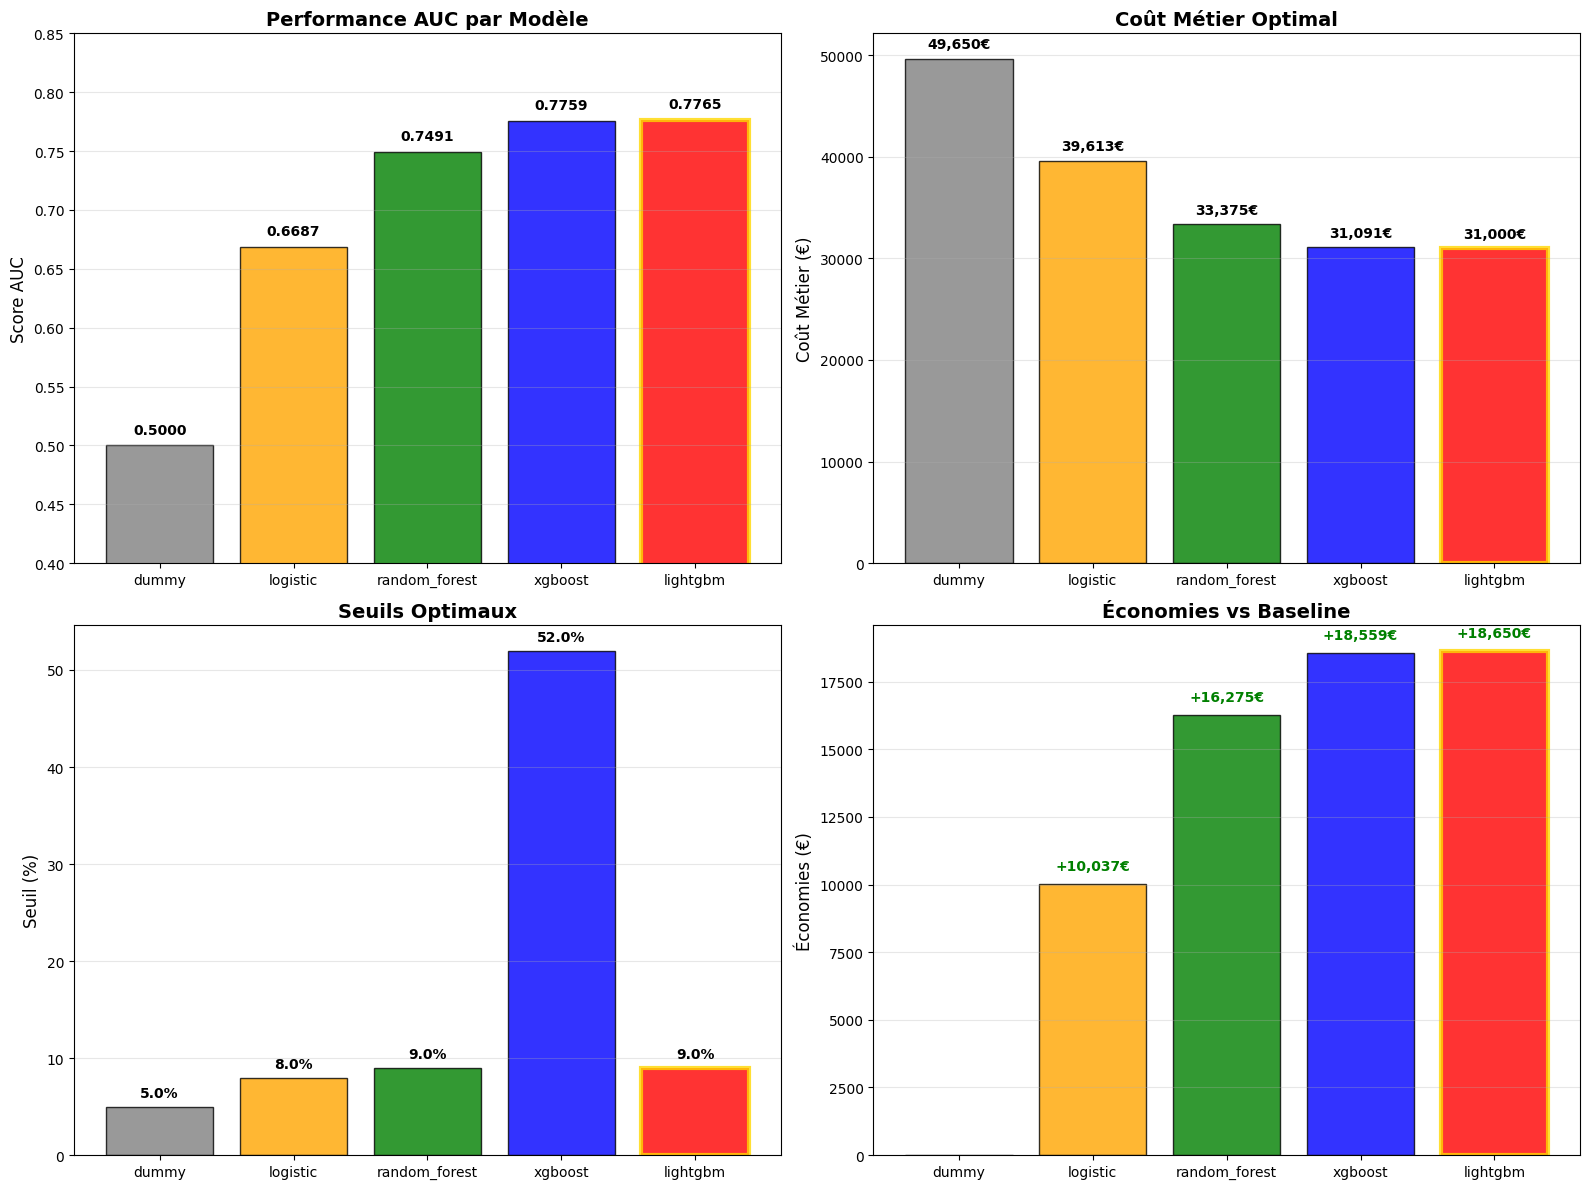


2. Courbes ROC...
  ‚úì Courbes ROC sauvegard√©es


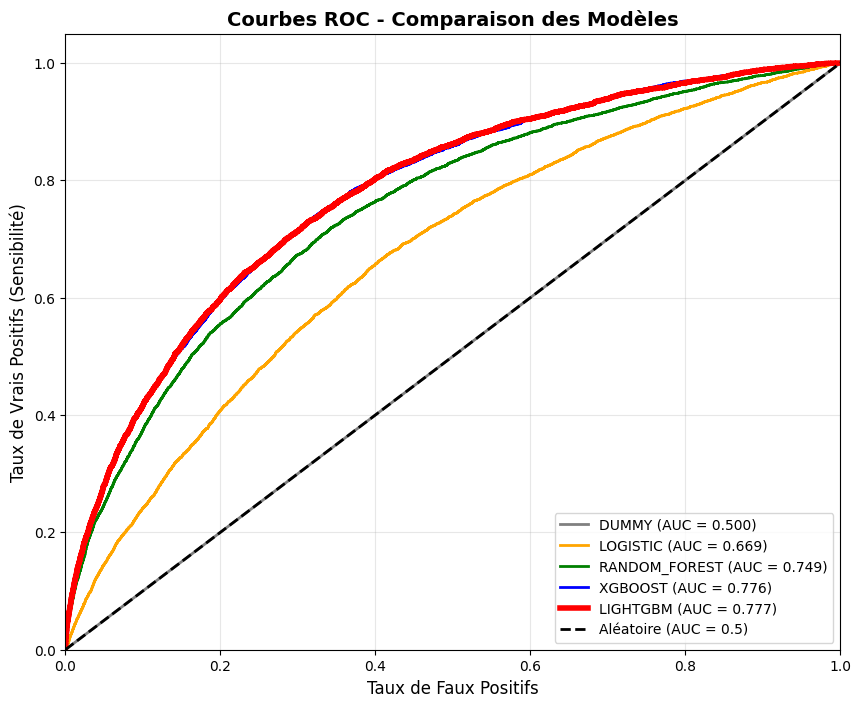


3. Matrices de confusion...
  ‚úì Matrices de confusion sauvegard√©es


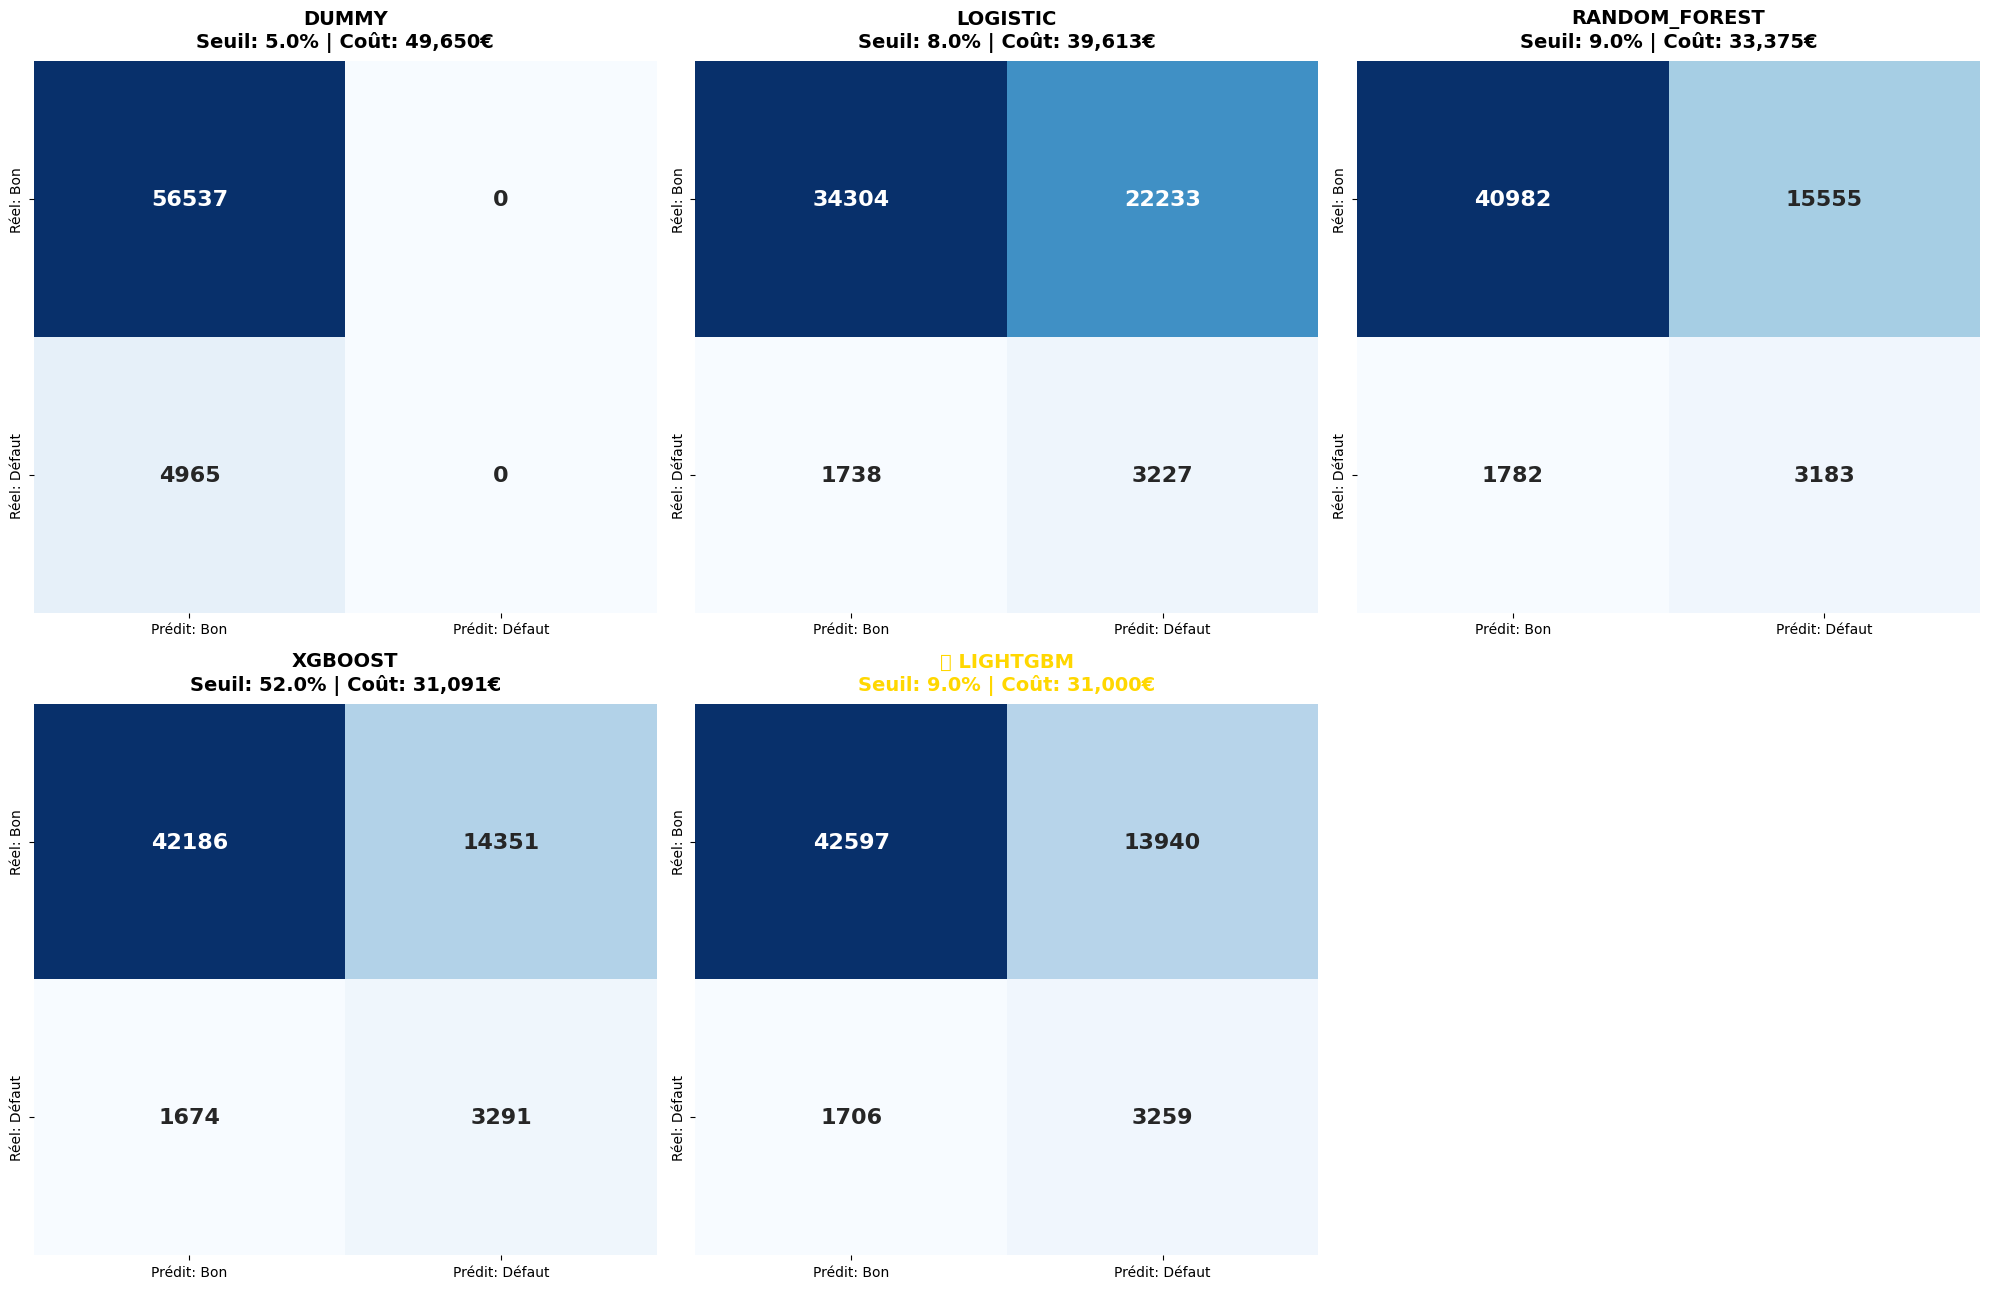


4. D√©composition des co√ªts...
  ‚úì D√©composition co√ªts sauvegard√©e


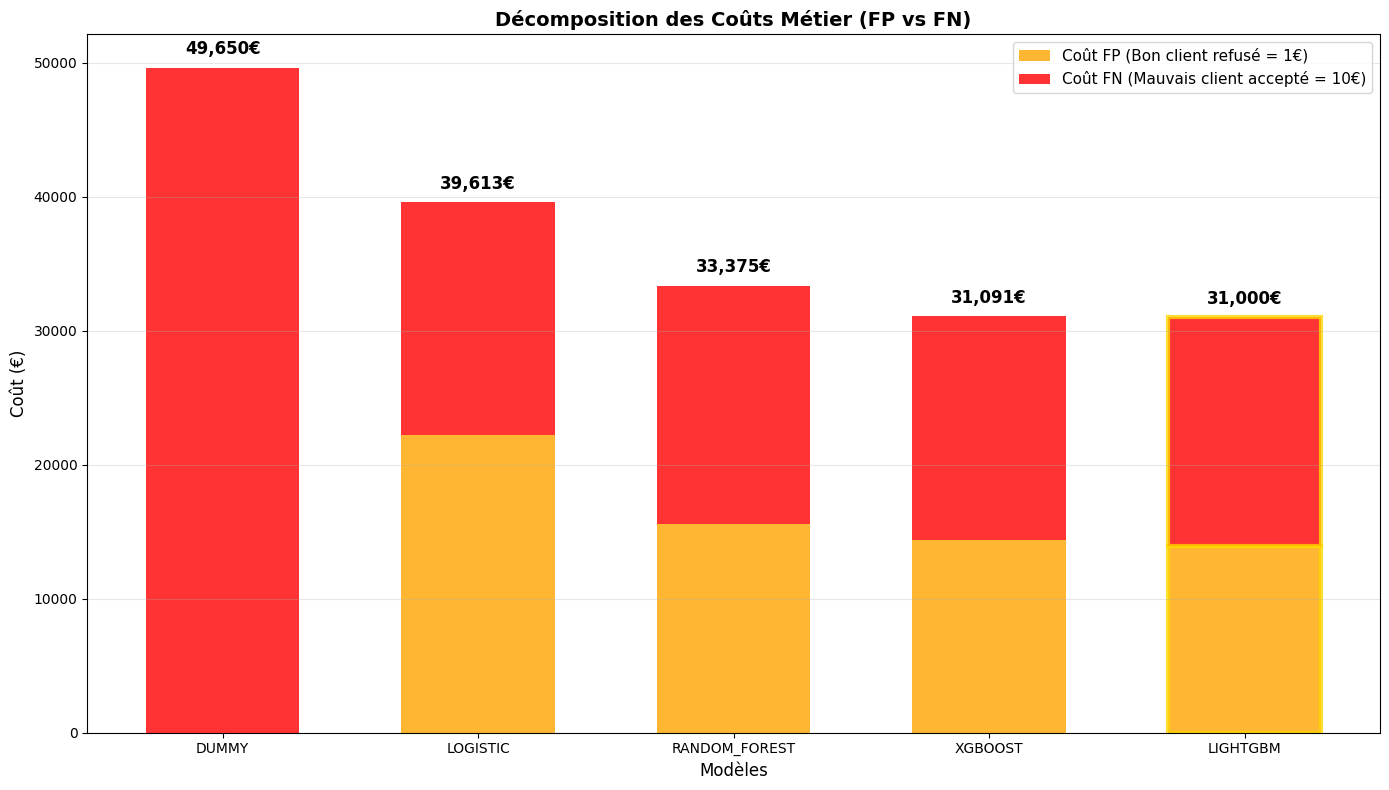


R√âSUM√â VISUEL
Champion: LIGHTGBM
Co√ªt: 31,000‚Ç¨
√âconomies: 18,650‚Ç¨ (-37.6%)

Graphiques cr√©√©s dans /visualizations/
‚úì Pr√™t pour l'interpr√©tabilit√© SHAP


In [8]:

print("="*60)
print("CR√âATION DES GRAPHIQUES D'ANALYSE")
print("="*60)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cr√©er dossier pour les graphiques
os.makedirs("visualizations", exist_ok=True)

# 1. TABLEAU COMPARATIF
print("\n1. Tableau comparatif des mod√®les...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = list(results_all.keys())
auc_scores = [results_all[m]['auc_val'] for m in models]
costs = [results_all[m]['min_cost'] for m in models]
thresholds = [results_all[m]['optimal_threshold'] for m in models]
colors = ['gray', 'orange', 'green', 'blue', 'red']

# 1.1 Comparaison AUC
ax = axes[0, 0]
bars = ax.bar(models, auc_scores, color=colors, alpha=0.8, edgecolor='black')
champion_idx = models.index(champion_name)
bars[champion_idx].set_edgecolor('gold')
bars[champion_idx].set_linewidth(3)
for i, v in enumerate(auc_scores):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
ax.set_ylabel('Score AUC', fontsize=12)
ax.set_title('Performance AUC par Mod√®le', fontsize=14, fontweight='bold')
ax.set_ylim([0.4, 0.85])
ax.grid(axis='y', alpha=0.3)

# 1.2 Comparaison Co√ªt M√©tier
ax = axes[0, 1]
bars = ax.bar(models, costs, color=colors, alpha=0.8, edgecolor='black')
bars[champion_idx].set_edgecolor('gold')
bars[champion_idx].set_linewidth(3)
for i, v in enumerate(costs):
    ax.text(i, v + 1000, f'{v:,.0f}‚Ç¨', ha='center', fontweight='bold', rotation=0)
ax.set_ylabel('Co√ªt M√©tier (‚Ç¨)', fontsize=12)
ax.set_title('Co√ªt M√©tier Optimal', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 1.3 Seuils optimaux
ax = axes[1, 0]
bars = ax.bar(models, [t*100 for t in thresholds], color=colors, alpha=0.8, edgecolor='black')
bars[champion_idx].set_edgecolor('gold')
bars[champion_idx].set_linewidth(3)
for i, v in enumerate(thresholds):
    ax.text(i, v*100 + 1, f'{v:.1%}', ha='center', fontweight='bold')
ax.set_ylabel('Seuil (%)', fontsize=12)
ax.set_title('Seuils Optimaux', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 1.4 √âconomies vs Baseline
ax = axes[1, 1]
baseline_cost = costs[0]
savings = [baseline_cost - cost for cost in costs]
bars = ax.bar(models, savings, color=colors, alpha=0.8, edgecolor='black')
bars[champion_idx].set_edgecolor('gold')
bars[champion_idx].set_linewidth(3)
for i, v in enumerate(savings):
    if v > 0:
        ax.text(i, v + 500, f'+{v:,.0f}‚Ç¨', ha='center', fontweight='bold', color='green')
ax.set_ylabel('√âconomies (‚Ç¨)', fontsize=12)
ax.set_title('√âconomies vs Baseline', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/01_comparison_overview.png', dpi=300, bbox_inches='tight')
print("  ‚úì Graphique comparatif sauvegard√©")
plt.show()

# 2. COURBES ROC
print("\n2. Courbes ROC...")
plt.figure(figsize=(10, 8))

for i, (model_name, result) in enumerate(results_all.items()):
    model = result['model']
    y_pred_proba = model.predict_proba(X_val_clean)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    linewidth = 4 if model_name == champion_name else 2
    plt.plot(fpr, tpr, color=colors[i], lw=linewidth,
             label=f'{model_name.upper()} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Al√©atoire (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (Sensibilit√©)', fontsize=12)
plt.title('Courbes ROC - Comparaison des Mod√®les', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('visualizations/02_roc_curves.png', dpi=300, bbox_inches='tight')
print("  ‚úì Courbes ROC sauvegard√©es")
plt.show()

# 3. MATRICES DE CONFUSION (GRANDES)
print("\n3. Matrices de confusion...")
fig, axes = plt.subplots(2, 3, figsize=(20, 13))
axes = axes.ravel()

for i, model_name in enumerate(models):
    model = results_all[model_name]['model']
    threshold = results_all[model_name]['optimal_threshold']
    cm_data = results_all[model_name]['confusion_matrix']
    
    cm = np.array([[cm_data['tn'], cm_data['fp']], 
                   [cm_data['fn'], cm_data['tp']]])
    
    # Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Pr√©dit: Bon', 'Pr√©dit: D√©faut'],
                yticklabels=['R√©el: Bon', 'R√©el: D√©faut'],
                cbar=False, annot_kws={'size': 16, 'weight': 'bold'})
    
    # Titre avec co√ªt
    cost = results_all[model_name]['min_cost']
    title_color = 'gold' if model_name == champion_name else 'black'
    marker = 'üèÜ ' if model_name == champion_name else ''
    axes[i].set_title(f'{marker}{model_name.upper()}\nSeuil: {threshold:.1%} | Co√ªt: {cost:,.0f}‚Ç¨',
                     fontsize=14, fontweight='bold', color=title_color, pad=10)
    
    # Bordure dor√©e pour le champion
    if model_name == champion_name:
        for spine in axes[i].spines.values():
            spine.set_edgecolor('gold')
            spine.set_linewidth(4)

# Masquer le dernier subplot vide
axes[5].set_visible(False)

plt.tight_layout()
plt.savefig('visualizations/03_confusion_matrices.png', dpi=300, bbox_inches='tight')
print("  ‚úì Matrices de confusion sauvegard√©es")
plt.show()

# 4. D√âCOMPOSITION DES CO√õTS
print("\n4. D√©composition des co√ªts...")
fig, ax = plt.subplots(figsize=(14, 8))

fp_costs = [results_all[m]['confusion_matrix']['fp'] for m in models]
fn_costs = [results_all[m]['confusion_matrix']['fn'] * 10 for m in models]

x = np.arange(len(models))
width = 0.6

bars1 = ax.bar(x, fp_costs, width, label='Co√ªt FP (Bon client refus√© = 1‚Ç¨)', 
               color='orange', alpha=0.8)
bars2 = ax.bar(x, fn_costs, width, bottom=fp_costs, 
               label='Co√ªt FN (Mauvais client accept√© = 10‚Ç¨)', 
               color='red', alpha=0.8)

# Marquer le champion
bars1[champion_idx].set_edgecolor('gold')
bars1[champion_idx].set_linewidth(3)
bars2[champion_idx].set_edgecolor('gold')
bars2[champion_idx].set_linewidth(3)

# Annotations
for i in range(len(models)):
    total = fp_costs[i] + fn_costs[i]
    ax.text(i, total + 1000, f'{total:,.0f}‚Ç¨', ha='center', fontweight='bold', fontsize=12)

ax.set_ylabel('Co√ªt (‚Ç¨)', fontsize=12)
ax.set_xlabel('Mod√®les', fontsize=12)
ax.set_title('D√©composition des Co√ªts M√©tier (FP vs FN)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in models])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/04_cost_breakdown.png', dpi=300, bbox_inches='tight')
print("  ‚úì D√©composition co√ªts sauvegard√©e")
plt.show()

print("\n" + "="*60)
print("R√âSUM√â VISUEL")
print("="*60)
print(f"Champion: {champion_name.upper()}")
print(f"Co√ªt: {results_all[champion_name]['min_cost']:,.0f}‚Ç¨")
print(f"√âconomies: {baseline_cost - results_all[champion_name]['min_cost']:,.0f}‚Ç¨ (-{((baseline_cost - results_all[champion_name]['min_cost'])/baseline_cost*100):.1f}%)")
print("\nGraphiques cr√©√©s dans /visualizations/")
print("‚úì Pr√™t pour l'interpr√©tabilit√© SHAP")

## FEATURE IMPORTANCE AVEC SHAP


MILESTONE 5 : INTERPR√âTABILIT√â - ANALYSE SHAP

Mod√®le analys√©: LIGHTGBM
Seuil de d√©cision: 9.0%

Cr√©ation de l'explainer SHAP...
Calcul des SHAP values sur 1000 observations...
‚úì SHAP values calcul√©es

1. Feature Importance globale...
  ‚úì Feature importance globale sauvegard√©e


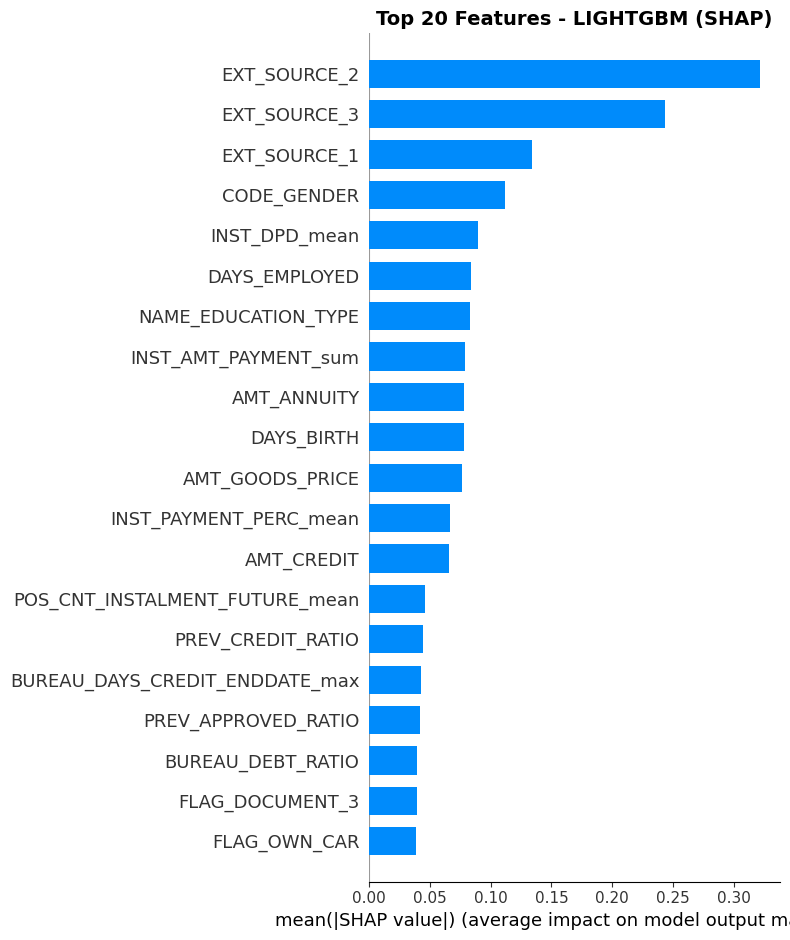


2. Summary plot avec impact...
  ‚úì Summary plot sauvegard√©


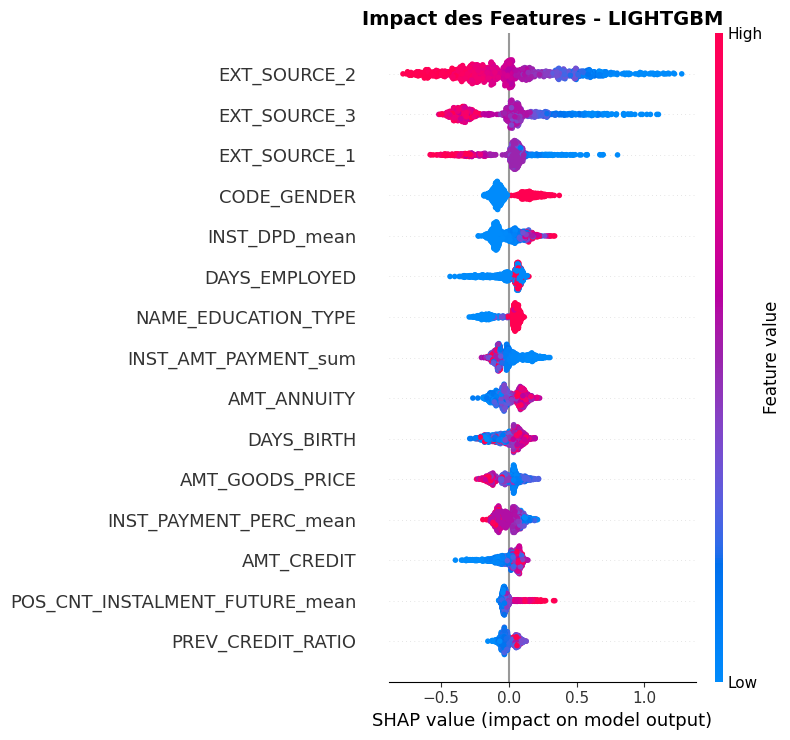


3. Top 15 features critiques...
  ‚úì Top 15 features sauvegard√©


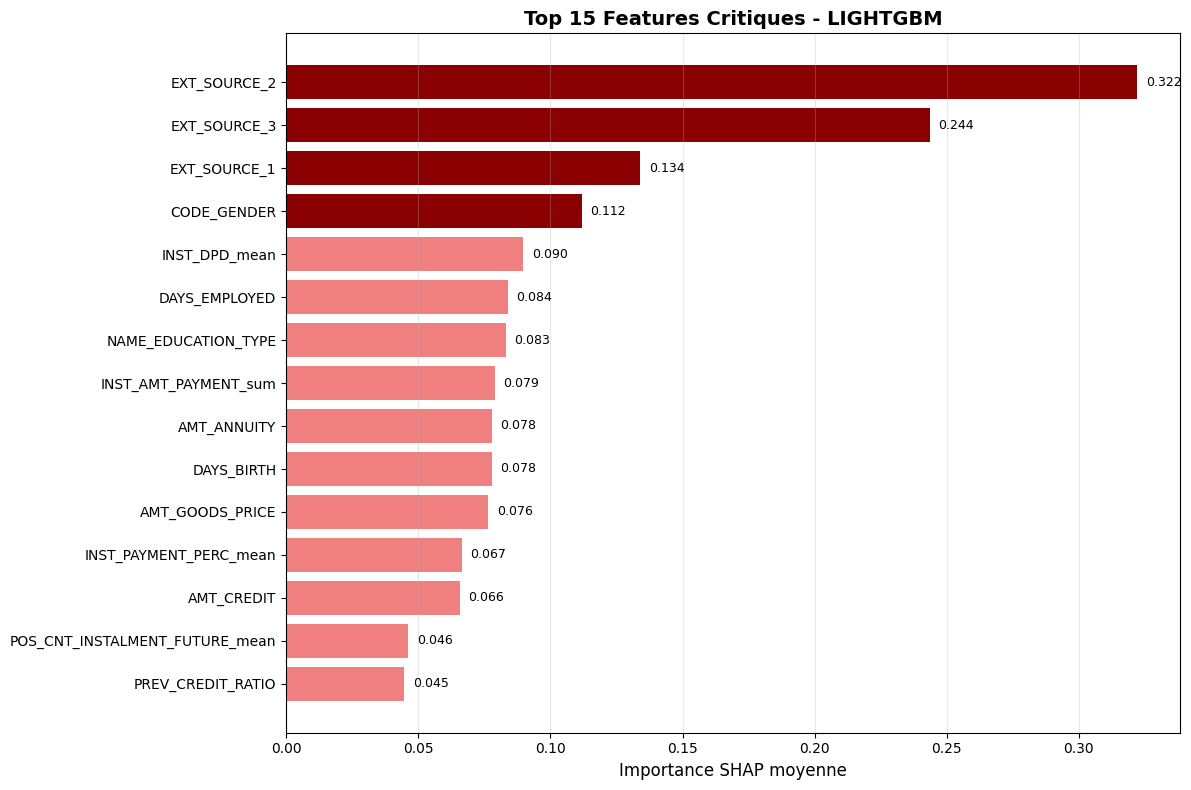


4. Exemples d'explications locales...


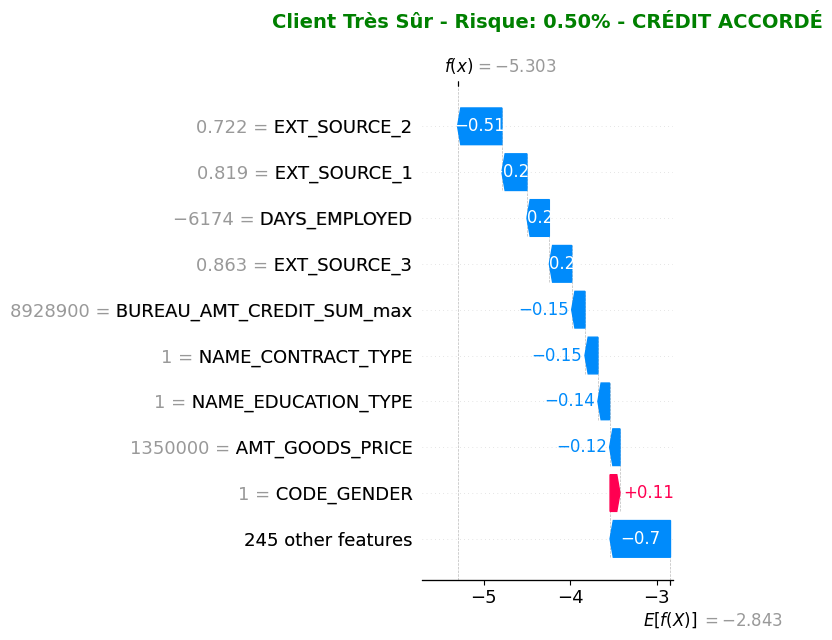

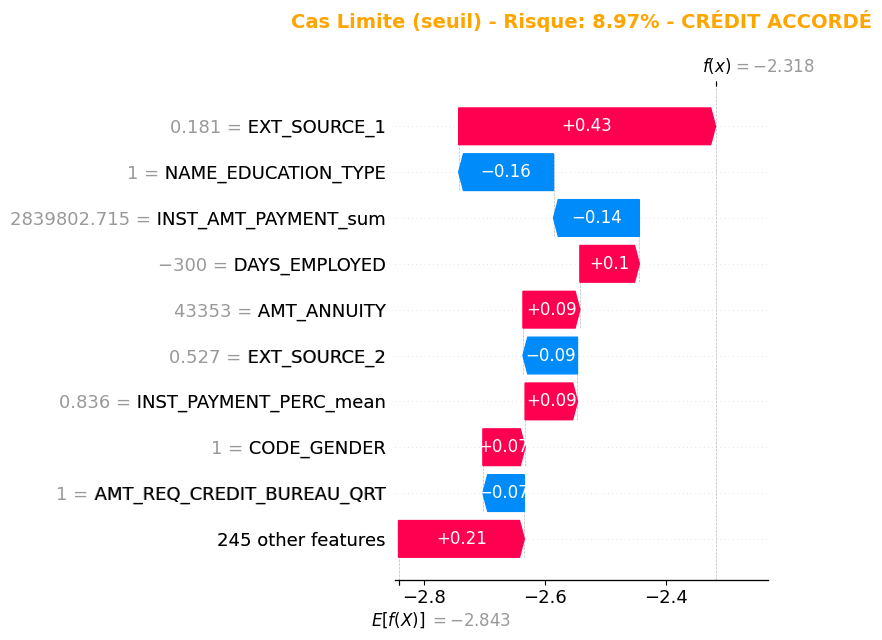

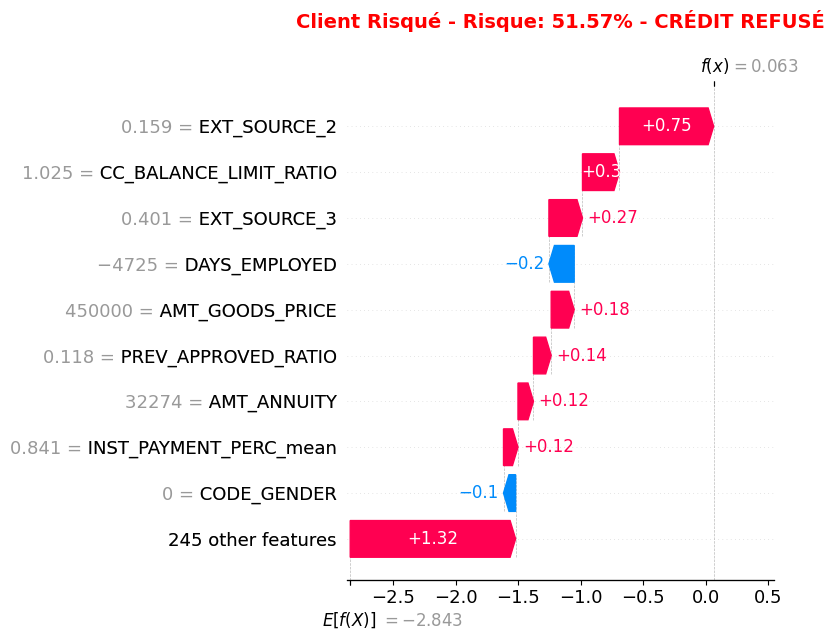

  ‚úì Waterfall plots sauvegard√©s

TOP 5 FEATURES CRITIQUES
1. EXT_SOURCE_2                        0.3221
2. EXT_SOURCE_3                        0.2437
3. EXT_SOURCE_1                        0.1339
4. CODE_GENDER                         0.1119
5. INST_DPD_mean                       0.0897

‚úì Objets SHAP sauvegard√©s pour l'API
‚úì Analyses SHAP termin√©es


In [10]:
# CELLULE 9 : FEATURE IMPORTANCE AVEC SHAP

print("="*60)
print("MILESTONE 5 : INTERPR√âTABILIT√â - ANALYSE SHAP")
print("="*60)

# Cr√©er le dossier models s'il n'existe pas
os.makedirs("../models", exist_ok=True)

# R√©cup√©rer le mod√®le champion
champion_model = results_all[champion_name]['model']

optimal_threshold = results_all[champion_name]['optimal_threshold']

print(f"\nMod√®le analys√©: {champion_name.upper()}")
print(f"Seuil de d√©cision: {optimal_threshold:.1%}")

# Cr√©er l'explainer SHAP adapt√© au type de mod√®le
print("\nCr√©ation de l'explainer SHAP...")
if champion_name in ['xgboost', 'lightgbm', 'random_forest']:
    explainer = shap.TreeExplainer(champion_model)
else:
    explainer = shap.Explainer(champion_model, X_train_clean)

# √âchantillon pour calcul SHAP (1000 observations)
sample_size = min(1000, len(X_val_clean))
X_sample = X_val_clean.iloc[:sample_size]
y_sample = y_val.iloc[:sample_size]

print(f"Calcul des SHAP values sur {sample_size} observations...")
shap_values = explainer(X_sample)

# Extraire les valeurs pour la classe positive (d√©faut)
if hasattr(shap_values, 'values') and len(shap_values.values.shape) == 3:
    shap_values_positive = shap_values.values[:, :, 1]
elif isinstance(shap_values, list):
    shap_values_positive = shap_values[1]
else:
    shap_values_positive = shap_values.values

print("‚úì SHAP values calcul√©es")

# Cr√©er dossier pour les graphiques SHAP
os.makedirs("shap_analysis", exist_ok=True)

# 1. FEATURE IMPORTANCE GLOBALE
print("\n1. Feature Importance globale...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive, X_sample, 
                 max_display=20, show=False, plot_type='bar')
plt.title(f'Top 20 Features - {champion_name.upper()} (SHAP)', 
         fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_analysis/01_global_importance.png', dpi=300, bbox_inches='tight')
print("  ‚úì Feature importance globale sauvegard√©e")
plt.show()

# 2. SUMMARY PLOT (impact et distribution)
print("\n2. Summary plot avec impact...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive, X_sample, 
                 max_display=15, show=False, plot_type='dot')
plt.title(f'Impact des Features - {champion_name.upper()}', 
         fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_analysis/02_summary_plot.png', dpi=300, bbox_inches='tight')
print("  ‚úì Summary plot sauvegard√©")
plt.show()

# 3. TOP 15 FEATURES AVEC VALEURS
print("\n3. Top 15 features critiques...")
feature_importance = np.abs(shap_values_positive).mean(0)
top_idx = np.argsort(feature_importance)[-15:]
top_features = X_sample.columns[top_idx]
top_importance = feature_importance[top_idx]

plt.figure(figsize=(12, 8))
colors_bars = ['darkred' if imp > np.percentile(top_importance, 75) else 'lightcoral' 
               for imp in top_importance]
bars = plt.barh(range(len(top_features)), top_importance, color=colors_bars)
plt.yticks(range(len(top_features)), top_features, fontsize=10)
plt.xlabel('Importance SHAP moyenne', fontsize=12)
plt.title(f'Top 15 Features Critiques - {champion_name.upper()}', 
         fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + max(top_importance) * 0.01, bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('shap_analysis/03_top15_features.png', dpi=300, bbox_inches='tight')
print("  ‚úì Top 15 features sauvegard√©")
plt.show()

# 4. WATERFALL PLOTS - Exemples clients
print("\n4. Exemples d'explications locales...")

y_pred_sample = champion_model.predict_proba(X_sample)[:, 1]

# Identifier 3 profils
low_risk_idx = np.argmin(y_pred_sample)
medium_risk_idx = np.argmin(np.abs(y_pred_sample - optimal_threshold))
high_risk_idx = np.argmax(y_pred_sample)

examples = [
    (low_risk_idx, "Client Tr√®s S√ªr", "green"),
    (medium_risk_idx, "Cas Limite (seuil)", "orange"),
    (high_risk_idx, "Client Risqu√©", "red")
]

for i, (idx, label, color) in enumerate(examples):
    risk = y_pred_sample[idx]
    decision = "CR√âDIT REFUS√â" if risk >= optimal_threshold else "CR√âDIT ACCORD√â"
    
    plt.figure(figsize=(14, 6))
    shap.waterfall_plot(shap.Explanation(
        values=shap_values_positive[idx],
        base_values=explainer.expected_value if hasattr(explainer, 'expected_value') else shap_values_positive.mean(),
        data=X_sample.iloc[idx].values,
        feature_names=X_sample.columns.tolist()
    ), max_display=10, show=False)
    
    plt.title(f'{label} - Risque: {risk:.2%} - {decision}', 
             fontsize=14, fontweight='bold', color=color, pad=20)
    plt.tight_layout()
    plt.savefig(f'shap_analysis/04_{i+1}_waterfall_{label.lower().replace(" ", "_")}.png', 
               dpi=300, bbox_inches='tight')
    plt.show()

print("  ‚úì Waterfall plots sauvegard√©s")

# R√âSUM√â QUANTITATIF
print("\n" + "="*60)
print("TOP 5 FEATURES CRITIQUES")
print("="*60)

top5_features = top_features[-5:][::-1]
top5_importance = top_importance[-5:][::-1]

for i, (feature, importance) in enumerate(zip(top5_features, top5_importance)):
    print(f"{i+1}. {feature:<35} {importance:.4f}")

# Sauvegarder objets SHAP pour API
joblib.dump(explainer, "../models/shap_explainer.pkl")
joblib.dump(shap_values_positive, "../models/shap_values_sample.pkl")

print("\n‚úì Objets SHAP sauvegard√©s pour l'API")
print("‚úì Analyses SHAP termin√©es")

## SAUVEGARDE MOD√àLE + PREPROCESSING POUR API


In [11]:
# CELLULE 10 : SAUVEGARDE MOD√àLE + PREPROCESSING POUR API (CORRIG√âE)
from datetime import datetime
print("="*60)
print("SAUVEGARDE COMPL√àTE POUR D√âPLOIEMENT")
print("="*60)

# Cr√©er dossier models s'il n'existe pas
os.makedirs("../models", exist_ok=True)

# 1. Mod√®le champion
print("\n1. Sauvegarde du mod√®le champion...")
joblib.dump(champion_model, "../models/champion_model.pkl")
print(f"  ‚úì {champion_name.upper()} sauvegard√©")

# 2. Seuil optimal
joblib.dump(champion_threshold, "../models/champion_threshold.pkl")
print(f"  ‚úì Seuil optimal: {champion_threshold:.3f}")

# 3. Colonnes features (ordre important)
feature_columns = X_train_clean.columns.tolist()
joblib.dump(feature_columns, "../models/feature_columns.pkl")
print(f"  ‚úì {len(feature_columns)} features sauvegard√©es")

# 4. Imputer
joblib.dump(imputer, "../models/imputer.pkl")
print("  ‚úì Imputer sauvegard√©")

# 5. M√©tadonn√©es compl√®tes
model_metadata = {
    'model_type': champion_name,
    'optimal_threshold': champion_threshold,
    'optimal_cost': results_all[champion_name]['min_cost'],
    'auc_score': results_all[champion_name]['auc_val'],
    'best_params': results_all[champion_name]['best_params'],
    'num_features': len(feature_columns),
    'confusion_matrix': results_all[champion_name]['confusion_matrix'],
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_train_size': len(X_train_clean),
    'dataset_val_size': len(X_val_clean)
}
joblib.dump(model_metadata, "../models/model_metadata.pkl")
print("  ‚úì M√©tadonn√©es sauvegard√©es")

# 6. R√©sultats tous mod√®les
results_summary = {}
for name, result in results_all.items():
    results_summary[name] = {
        'auc': result['auc_val'],
        'cost': result['min_cost'],
        'threshold': result['optimal_threshold'],
        'params': result['best_params']
    }
joblib.dump(results_summary, "../models/all_models_results.pkl")
print("  ‚úì R√©sultats de tous les mod√®les sauvegard√©s")

# V√©rification des fichiers
print("\n" + "="*60)
print("FICHIERS DANS /models/")
print("="*60)
for file in sorted(os.listdir("../models")):
    if file.endswith('.pkl'):
        size = os.path.getsize(f"../models/{file}") / 1024
        print(f"  {file:<40} {size:>8.1f} KB")

# Test de chargement
print("\n" + "="*60)
print("TEST DE CHARGEMENT")
print("="*60)
try:
    model_test = joblib.load("../models/champion_model.pkl")
    threshold_test = joblib.load("../models/champion_threshold.pkl")
    metadata_test = joblib.load("../models/model_metadata.pkl")
    
    print(f"‚úì Mod√®le charg√©: {metadata_test['model_type']}")
    print(f"‚úì Seuil charg√©: {threshold_test:.3f}")
    print(f"‚úì Type mod√®le: {type(model_test).__name__}")
    
    # Test pr√©diction
    test_pred = model_test.predict_proba(X_val_clean.iloc[:5])
    print(f"‚úì Test pr√©diction OK: {test_pred.shape}")
    
except Exception as e:
    print(f"‚ùå Erreur: {e}")

print("\n" + "="*60)
print("R√âSUM√â D√âPLOIEMENT")
print("="*60)
print(f"Champion: {champion_name.upper()}")
print(f"AUC: {results_all[champion_name]['auc_val']:.4f}")
print(f"Co√ªt: {results_all[champion_name]['min_cost']:,.0f}‚Ç¨")
print(f"Seuil: {champion_threshold:.1%}")
print(f"Features: {len(feature_columns)}")
print("\n‚úì Mod√®le pr√™t pour API")

SAUVEGARDE COMPL√àTE POUR D√âPLOIEMENT

1. Sauvegarde du mod√®le champion...
  ‚úì LIGHTGBM sauvegard√©
  ‚úì Seuil optimal: 0.090
  ‚úì 254 features sauvegard√©es
  ‚úì Imputer sauvegard√©
  ‚úì M√©tadonn√©es sauvegard√©es
  ‚úì R√©sultats de tous les mod√®les sauvegard√©s

FICHIERS DANS /models/
  all_models_results.pkl                        0.7 KB
  champion_model.pkl                          360.5 KB
  champion_threshold.pkl                        0.1 KB
  feature_columns.pkl                           6.0 KB
  imputer.pkl                                   8.7 KB
  model_metadata.pkl                            0.5 KB
  shap_explainer.pkl                          879.8 KB
  shap_values_sample.pkl                     1984.6 KB

TEST DE CHARGEMENT
‚úì Mod√®le charg√©: lightgbm
‚úì Seuil charg√©: 0.090
‚úì Type mod√®le: LGBMClassifier
‚úì Test pr√©diction OK: (5, 2)

R√âSUM√â D√âPLOIEMENT
Champion: LIGHTGBM
AUC: 0.7765
Co√ªt: 31,000‚Ç¨
Seuil: 9.0%
Features: 254

‚úì Mod√®le pr√™t pour 

## MILESTONE 8 - ANALYSE DATA DRIFT


MILESTONE 8 : ANALYSE DATA DRIFT

Simulation selon cahier des charges:
- R√©f√©rence (train) = application_train.csv
- Production (test) = application_test.csv (validation set)

Dataset r√©f√©rence: (2000, 254)
Dataset production: (2000, 254)
Features analys√©es: 9

Analyse statistique du drift...
  ‚ö†Ô∏è  DRIFT d√©tect√© - EXT_SOURCE_2
      KS p-value: 0.0290
      Changement: 0.046 std

R√âSULTATS DATA DRIFT
Features avec drift: 1/9
Pourcentage: 11.1%
Niveau: DRIFT MINEUR
Risque mod√®le: FAIBLE

‚úì Graphique sauvegard√©: reports/data_drift_analysis.png


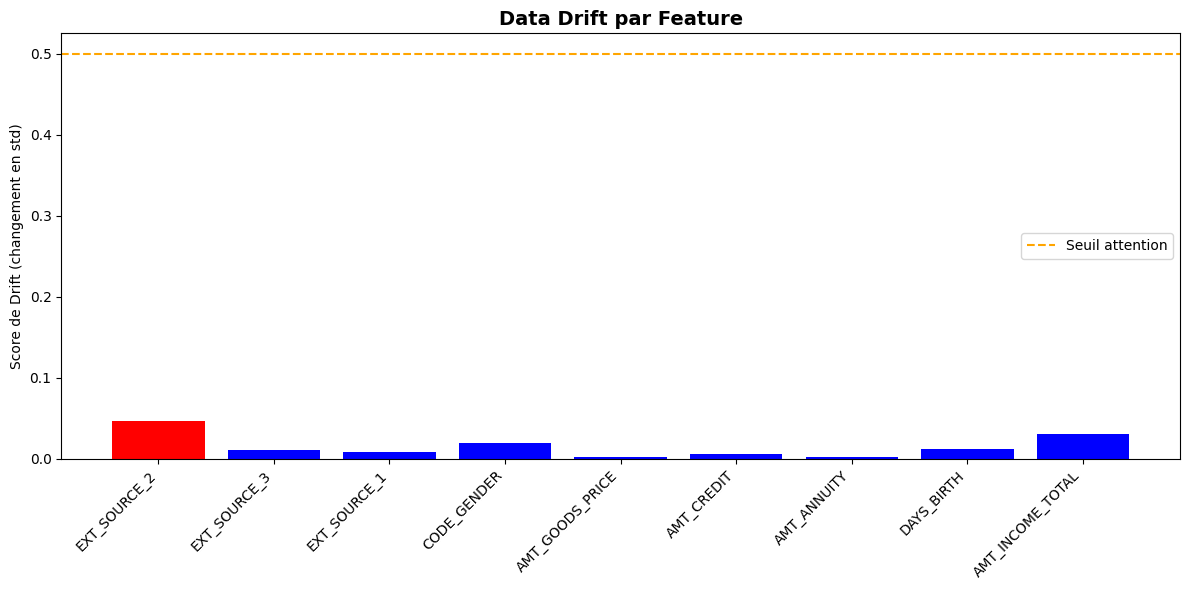

‚úì Rapport HTML sauvegard√©: reports/data_drift_report.html

MILESTONE 8 VALID√â
Statut: DRIFT MINEUR - Risque FAIBLE


In [12]:
print("="*60)
print("MILESTONE 8 : ANALYSE DATA DRIFT")
print("="*60)

print("\nSimulation selon cahier des charges:")
print("- R√©f√©rence (train) = application_train.csv")
print("- Production (test) = application_test.csv (validation set)")

# Utiliser train et validation comme r√©f√©rence vs production
reference_data = X_train_clean.sample(n=min(2000, len(X_train_clean)), random_state=42)
production_data = X_val_clean.sample(n=min(2000, len(X_val_clean)), random_state=42)

print(f"\nDataset r√©f√©rence: {reference_data.shape}")
print(f"Dataset production: {production_data.shape}")

# S√©lectionner les features importantes pour l'analyse
important_features = [
    'EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1',
    'CODE_GENDER', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
    'AMT_ANNUITY', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL'
]

# Filtrer les colonnes disponibles
available_features = [f for f in important_features if f in reference_data.columns]
print(f"Features analys√©es: {len(available_features)}")

# Cr√©er dossier pour les rapports
os.makedirs("reports", exist_ok=True)

# Analyse Data Drift
print("\nAnalyse statistique du drift...")
drift_results = {}
significant_drifts = []

for feature in available_features:
    ref_values = reference_data[feature].dropna()
    prod_values = production_data[feature].dropna()
    
    if len(ref_values) > 50 and len(prod_values) > 50:
        # Test Kolmogorov-Smirnov
        ks_stat, ks_pvalue = stats.ks_2samp(ref_values, prod_values)
        
        # Statistiques descriptives
        ref_mean = ref_values.mean()
        prod_mean = prod_values.mean()
        ref_std = ref_values.std()
        prod_std = prod_values.std()
        
        # Score de drift
        mean_shift = abs(prod_mean - ref_mean) / ref_std if ref_std > 0 else 0
        
        drift_results[feature] = {
            'ks_statistic': ks_stat,
            'ks_pvalue': ks_pvalue,
            'ref_mean': ref_mean,
            'prod_mean': prod_mean,
            'mean_shift': mean_shift,
            'drift_detected': ks_pvalue < 0.05
        }
        
        if ks_pvalue < 0.05:
            significant_drifts.append(feature)
            print(f"  ‚ö†Ô∏è  DRIFT d√©tect√© - {feature}")
            print(f"      KS p-value: {ks_pvalue:.4f}")
            print(f"      Changement: {mean_shift:.3f} std")

# M√©triques globales
drift_percentage = len(significant_drifts) / len(available_features) * 100

print(f"\n{'='*60}")
print("R√âSULTATS DATA DRIFT")
print(f"{'='*60}")
print(f"Features avec drift: {len(significant_drifts)}/{len(available_features)}")
print(f"Pourcentage: {drift_percentage:.1f}%")

if drift_percentage == 0:
    drift_level = "AUCUN DRIFT"
    risk = "FAIBLE"
elif drift_percentage <= 20:
    drift_level = "DRIFT MINEUR"
    risk = "FAIBLE"
elif drift_percentage <= 40:
    drift_level = "DRIFT MOD√âR√â"
    risk = "MOYEN"
else:
    drift_level = "DRIFT MAJEUR"
    risk = "√âLEV√â"

print(f"Niveau: {drift_level}")
print(f"Risque mod√®le: {risk}")

# Graphique
plt.figure(figsize=(12, 6))
features_list = list(drift_results.keys())
drift_scores = [drift_results[f]['mean_shift'] for f in features_list]
colors_drift = ['red' if f in significant_drifts else 'blue' for f in features_list]

plt.bar(range(len(features_list)), drift_scores, color=colors_drift)
plt.xticks(range(len(features_list)), features_list, rotation=45, ha='right')
plt.ylabel('Score de Drift (changement en std)')
plt.title('Data Drift par Feature', fontsize=14, fontweight='bold')
plt.axhline(y=0.5, color='orange', linestyle='--', label='Seuil attention')
plt.legend()
plt.tight_layout()
plt.savefig('reports/data_drift_analysis.png', dpi=300, bbox_inches='tight')
print("\n‚úì Graphique sauvegard√©: reports/data_drift_analysis.png")
plt.show()

# Rapport HTML
html_report = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Analyse Data Drift - Projet 7</title>
    <style>
        body {{ font-family: Arial; margin: 40px; }}
        .header {{ background: #2E86AB; color: white; padding: 20px; }}
        .summary {{ background: #f0f0f0; padding: 15px; margin: 20px 0; }}
        table {{ border-collapse: collapse; width: 100%; }}
        th, td {{ border: 1px solid #ddd; padding: 8px; }}
        th {{ background: #f2f2f2; }}
        .drift {{ color: red; font-weight: bold; }}
    </style>
</head>
<body>
    <div class="header">
        <h1>Analyse Data Drift - Scoring Cr√©dit</h1>
        <p>Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
    </div>
    
    <div class="summary">
        <h2>R√©sum√©</h2>
        <ul>
            <li>Features analys√©es: {len(available_features)}</li>
            <li>Features avec drift: {len(significant_drifts)} ({drift_percentage:.1f}%)</li>
            <li>Niveau: {drift_level}</li>
            <li>Risque: {risk}</li>
        </ul>
    </div>
    
    <h2>D√©tails par Feature</h2>
    <table>
        <tr>
            <th>Feature</th>
            <th>Drift D√©tect√©</th>
            <th>KS p-value</th>
            <th>Changement</th>
        </tr>
"""

for feature in features_list:
    result = drift_results[feature]
    drift_status = "OUI" if result['drift_detected'] else "NON"
    row_class = "drift" if result['drift_detected'] else ""
    
    html_report += f"""
        <tr class="{row_class}">
            <td>{feature}</td>
            <td>{drift_status}</td>
            <td>{result['ks_pvalue']:.4f}</td>
            <td>{result['mean_shift']:.3f}</td>
        </tr>
    """

html_report += """
    </table>
    
    <h2>Recommandations</h2>
    <div class="summary">
"""

if drift_percentage == 0:
    html_report += "<p>‚úÖ Mod√®le stable - Surveillance standard</p>"
elif drift_percentage <= 20:
    html_report += "<p>‚ö†Ô∏è Surveillance accrue recommand√©e</p>"
else:
    html_report += "<p>üö® Consid√©rer un r√©-entra√Ænement</p>"

html_report += """
    </div>
</body>
</html>
"""

# Sauvegarder rapport HTML
with open("reports/data_drift_report.html", 'w', encoding='utf-8') as f:
    f.write(html_report)

print("‚úì Rapport HTML sauvegard√©: reports/data_drift_report.html")

print(f"\n{'='*60}")
print("MILESTONE 8 VALID√â")
print(f"{'='*60}")
print(f"Statut: {drift_level} - Risque {risk}")

## CR√âATION DES TESTS UNITAIRES


In [13]:

print("="*60)
print("CR√âATION DES TESTS UNITAIRES")
print("="*60)

# Cr√©er le dossier tests
os.makedirs("tests", exist_ok=True)

# 1. test_model.py
test_model_code = '''
import unittest
import joblib
import numpy as np
import pandas as pd

class TestChampionModel(unittest.TestCase):
    
    @classmethod
    def setUpClass(cls):
        """Charger le mod√®le une fois pour tous les tests"""
        cls.model = joblib.load("models/champion_model.pkl")
        cls.threshold = joblib.load("models/champion_threshold.pkl")
        cls.features = joblib.load("models/feature_columns.pkl")
        cls.metadata = joblib.load("models/model_metadata.pkl")
    
    def test_model_loaded(self):
        """Test: Le mod√®le est bien charg√©"""
        self.assertIsNotNone(self.model)
        
    def test_threshold_range(self):
        """Test: Le seuil est dans [0, 1]"""
        self.assertGreaterEqual(self.threshold, 0)
        self.assertLessEqual(self.threshold, 1)
        
    def test_features_count(self):
        """Test: Nombre de features coh√©rent"""
        self.assertEqual(len(self.features), 254)
        
    def test_prediction_shape(self):
        """Test: Shape des pr√©dictions"""
        X_test = pd.DataFrame(np.random.randn(10, 254), columns=self.features)
        pred = self.model.predict_proba(X_test)
        self.assertEqual(pred.shape, (10, 2))
        
    def test_prediction_range(self):
        """Test: Probabilit√©s dans [0, 1]"""
        X_test = pd.DataFrame(np.random.randn(5, 254), columns=self.features)
        pred = self.model.predict_proba(X_test)
        self.assertTrue(np.all(pred >= 0))
        self.assertTrue(np.all(pred <= 1))

if __name__ == "__main__":
    unittest.main()
'''

# 2. test_business.py
test_business_code = '''
import unittest
import numpy as np
from sklearn.metrics import confusion_matrix

class TestBusinessLogic(unittest.TestCase):
    
    def test_cost_calculation(self):
        """Test: Calcul co√ªt m√©tier 10*FN + FP"""
        fn, fp = 100, 500
        cost = 10 * fn + fp
        self.assertEqual(cost, 1500)
        
    def test_threshold_logic(self):
        """Test: Application du seuil"""
        probas = np.array([0.05, 0.08, 0.09, 0.12])
        threshold = 0.09
        predictions = (probas >= threshold).astype(int)
        expected = np.array([0, 0, 0, 1])
        np.testing.assert_array_equal(predictions, expected)
        
    def test_confusion_matrix_cost(self):
        """Test: Co√ªt depuis matrice de confusion"""
        y_true = np.array([0, 0, 1, 1, 0, 1])
        y_pred = np.array([0, 1, 0, 1, 0, 0])
        
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = 10 * fn + fp
        
        # FN=2 (indices 2,5), FP=1 (indice 1)
        self.assertEqual(fn, 2)
        self.assertEqual(fp, 1)
        self.assertEqual(cost, 21)

if __name__ == "__main__":
    unittest.main()
'''

# 3. test_preprocessing.py
test_preprocessing_code = '''
import unittest
import joblib
import pandas as pd
import numpy as np

class TestPreprocessing(unittest.TestCase):
    
    @classmethod
    def setUpClass(cls):
        """Charger l'imputer"""
        cls.imputer = joblib.load("models/imputer.pkl")
        cls.features = joblib.load("models/feature_columns.pkl")
    
    def test_imputer_loaded(self):
        """Test: Imputer charg√©"""
        self.assertIsNotNone(self.imputer)
        
    def test_imputation(self):
        """Test: Imputation des NaN"""
        X_test = pd.DataFrame(np.random.randn(5, 254), columns=self.features)
        X_test.iloc[0, 0] = np.nan
        
        X_imputed = self.imputer.transform(X_test)
        self.assertFalse(np.isnan(X_imputed).any())

if __name__ == "__main__":
    unittest.main()
'''

# √âcrire les fichiers
test_files = {
    "tests/test_model.py": test_model_code,
    "tests/test_business.py": test_business_code,
    "tests/test_preprocessing.py": test_preprocessing_code,
    "tests/__init__.py": "# Tests package"
}

for filepath, content in test_files.items():
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(content.strip())
    print(f"‚úì {filepath}")

# 4. Script d'ex√©cution des tests
run_tests_code = '''
import unittest
import sys

def run_all_tests():
    """Lancer tous les tests"""
    loader = unittest.TestLoader()
    suite = loader.discover("tests", pattern="test_*.py")
    
    runner = unittest.TextTestRunner(verbosity=2)
    result = runner.run(suite)
    
    print(f"\\n{'='*60}")
    print("R√âSUM√â DES TESTS")
    print(f"{'='*60}")
    print(f"Tests ex√©cut√©s: {result.testsRun}")
    print(f"R√©ussis: {result.testsRun - len(result.failures) - len(result.errors)}")
    print(f"√âchecs: {len(result.failures)}")
    print(f"Erreurs: {len(result.errors)}")
    
    success_rate = ((result.testsRun - len(result.failures) - len(result.errors)) / 
                    max(result.testsRun, 1) * 100)
    print(f"Taux de r√©ussite: {success_rate:.1f}%")
    
    return result.wasSuccessful()

if __name__ == "__main__":
    success = run_all_tests()
    sys.exit(0 if success else 1)
'''

with open("run_tests.py", 'w', encoding='utf-8') as f:
    f.write(run_tests_code.strip())

print("‚úì run_tests.py")

print(f"\n{'='*60}")
print("TESTS CR√â√âS")
print(f"{'='*60}")
print("Pour lancer les tests:")
print("  python run_tests.py")
print("\nOu individuellement:")
print("  python -m unittest tests.test_model")
print("  python -m unittest tests.test_business")
print("  python -m unittest tests.test_preprocessing")

CR√âATION DES TESTS UNITAIRES
‚úì tests/test_model.py
‚úì tests/test_business.py
‚úì tests/test_preprocessing.py
‚úì tests/__init__.py
‚úì run_tests.py

TESTS CR√â√âS
Pour lancer les tests:
  python run_tests.py

Ou individuellement:
  python -m unittest tests.test_model
  python -m unittest tests.test_business
  python -m unittest tests.test_preprocessing


## EXPORT DE VRAIS CLIENTS POUR D√âMO

In [14]:
print("="*60)
print("EXPORT CLIENTS TEST AVEC ID R√âELS")
print("="*60)

# R√©cup√©rer les SK_ID_CURR depuis le dataset original pour le test
# X_test_clean contient les index qui correspondent aux SK_ID_CURR de train_final
test_ids = train_final.loc[X_test_clean.index, 'SK_ID_CURR']

# Pr√©dictions sur le test
y_pred_proba_test = champion_model.predict_proba(X_test_clean)[:, 1]

# Cr√©er dataset avec SK_ID_CURR en premi√®re colonne
all_clients_test = X_test_clean.copy()
all_clients_test.insert(0, 'SK_ID_CURR', test_ids.values)
all_clients_test['RISK_SCORE'] = y_pred_proba_test
all_clients_test['DECISION'] = ['ACCORD' if r < champion_threshold else 'REFUS' 
                                 for r in y_pred_proba_test]
all_clients_test['REAL_TARGET'] = y_test.values

# Sauvegarder
all_clients_test.to_csv('../all_clients_test.csv', index=False)

print(f"\nClients test export√©s: {len(all_clients_test):,}")
print(f"Avec SK_ID_CURR de {test_ids.min()} √† {test_ids.max()}")
print(f"Cr√©dits accord√©s: {(all_clients_test['DECISION']=='ACCORD').sum():,}")
print(f"Cr√©dits refus√©s: {(all_clients_test['DECISION']=='REFUS').sum():,}")

# V√©rification
print(f"\nPremiers clients:")
print(all_clients_test[['SK_ID_CURR', 'RISK_SCORE', 'DECISION', 'REAL_TARGET']].head())
print("\nFichier: all_clients_test.csv cr√©√©")

EXPORT CLIENTS TEST AVEC ID R√âELS

Clients test export√©s: 61,503
Avec SK_ID_CURR de 100006 √† 456249
Cr√©dits accord√©s: 44,299
Cr√©dits refus√©s: 17,204

Premiers clients:
        SK_ID_CURR  RISK_SCORE DECISION  REAL_TARGET
56927       165983    0.064049   ACCORD            0
123777      243541    0.176452    REFUS            1
146023      269316    0.033130   ACCORD            0
255457      395592    0.323734    REFUS            1
278763      422945    0.107780    REFUS            0

Fichier: all_clients_test.csv cr√©√©


## R√âCAPITULATIF ET VALIDATION FINALE


In [16]:
print("="*60)
print("R√âCAPITULATIF DU PROJET - VALIDATION DES LIVRABLES")
print("="*60)

import os
from pathlib import Path

def check_files(folder, files):
    """V√©rifier l'existence des fichiers"""
    results = []
    for file in files:
        path = Path(folder) / file
        exists = path.exists()
        size = path.stat().st_size if exists else 0
        results.append((file, exists, size))
    return results

# 1. MOD√àLES SAUVEGARD√âS
print("\n1. MOD√àLES ET PREPROCESSING")
print("-" * 60)
model_files = [
    "champion_model.pkl",
    "champion_threshold.pkl",
    "feature_columns.pkl",
    "imputer.pkl",
    "model_metadata.pkl",
    "shap_explainer.pkl"
]
for file, exists, size in check_files("../models", model_files):
    status = "OK" if exists else "MANQUANT"
    print(f"  {status:8} {file:<35} {size/1024:>8.1f} KB")

# 2. VISUALISATIONS
print("\n2. VISUALISATIONS")
print("-" * 60)
viz_files = [
    "01_comparison_overview.png",
    "02_roc_curves.png",
    "03_confusion_matrices.png",
    "04_cost_breakdown.png"
]
for file, exists, size in check_files("../visualizations", viz_files):
    status = "OK" if exists else "MANQUANT"
    print(f"  {status:8} {file:<35}")

# 3. ANALYSES SHAP
print("\n3. ANALYSES SHAP")
print("-" * 60)
shap_files = [
    "01_global_importance.png",
    "02_summary_plot.png",
    "03_top15_features.png"
]
for file, exists, size in check_files("../shap_analysis", shap_files):
    status = "OK" if exists else "MANQUANT"
    print(f"  {status:8} {file:<35}")

# 4. MLFLOW
print("\n4. MLFLOW TRACKING")
print("-" * 60)
mlruns_path = Path("../mlruns")
if mlruns_path.exists():
    experiments = list(mlruns_path.glob("*/"))
    print(f"  OK       MLflow configur√© ({len(experiments)} experiments)")
    print(f"           Pour visualiser: mlflow ui")
else:
    print(f"  MANQUANT Dossier mlruns")

# 5. R√âSULTATS DU CHAMPION
print("\n" + "="*60)
print("R√âSULTATS DU MOD√àLE CHAMPION")
print("="*60)
metadata = joblib.load("../models/model_metadata.pkl")
print(f"Mod√®le: {metadata['model_type'].upper()}")
print(f"AUC: {metadata['auc_score']:.4f}")
print(f"Co√ªt optimal: {metadata['optimal_cost']:,.0f}‚Ç¨")
print(f"Seuil optimal: {metadata['optimal_threshold']:.1%}")
print(f"Features: {metadata['num_features']}")
print(f"Date entra√Ænement: {metadata['training_date']}")

cm = metadata['confusion_matrix']
print(f"\nMatrice de confusion:")
print(f"  TN (bon ‚Üí bon): {cm['tn']:,}")
print(f"  FP (bon ‚Üí d√©faut): {cm['fp']:,}")
print(f"  FN (d√©faut ‚Üí bon): {cm['fn']:,}")
print(f"  TP (d√©faut ‚Üí d√©faut): {cm['tp']:,}")

# 6. VALIDATION DES MILESTONES
print("\n" + "="*60)
print("VALIDATION DES MILESTONES DU GUIDE MENTOR")
print("="*60)

milestones = [
    ("Milestone 1", "MLFlow configur√©", mlruns_path.exists()),
    ("Milestone 2", "Feature Engineering", Path("../models/feature_columns.pkl").exists()),
    ("Milestone 3", "Score m√©tier", metadata['optimal_cost'] < 50000),
    ("Milestone 4", "Mod√®les compar√©s", Path("../models/all_models_results.pkl").exists()),
    ("Milestone 5", "SHAP", Path("../models/shap_explainer.pkl").exists()),
    ("Milestone 6", "Mod√®le pour API", Path("../models/champion_model.pkl").exists()),
]

for milestone, description, validated in milestones:
    status = "VALID√â" if validated else "√Ä FAIRE"
    symbol = "‚úì" if validated else "‚úó"
    print(f"  {symbol} {milestone}: {description} - {status}")

print("\n" + "="*60)
print("NOTEBOOK TERMIN√â - PR√äT POUR API/DASHBOARD")
print("="*60)

R√âCAPITULATIF DU PROJET - VALIDATION DES LIVRABLES

1. MOD√àLES ET PREPROCESSING
------------------------------------------------------------
  OK       champion_model.pkl                     360.5 KB
  OK       champion_threshold.pkl                   0.1 KB
  OK       feature_columns.pkl                      6.0 KB
  OK       imputer.pkl                              8.7 KB
  OK       model_metadata.pkl                       0.5 KB
  OK       shap_explainer.pkl                     879.8 KB

2. VISUALISATIONS
------------------------------------------------------------
  MANQUANT 01_comparison_overview.png         
  MANQUANT 02_roc_curves.png                  
  MANQUANT 03_confusion_matrices.png          
  MANQUANT 04_cost_breakdown.png              

3. ANALYSES SHAP
------------------------------------------------------------
  MANQUANT 01_global_importance.png           
  MANQUANT 02_summary_plot.png                
  MANQUANT 03_top15_features.png              

4. MLFLOW TRAC

In [17]:
import mlflow
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri("file:///C:/Users/amine/Desktop/projet_openclassrooms/projet_scoring_credit/notebooks/mlruns")
client = MlflowClient()

for exp in client.search_experiments():
    print(f"Exp: {exp.name}")
    runs = client.search_runs([exp.experiment_id])
    for r in runs:
        print(f"  Run ID: {r.info.run_id}, metrics: {dict(r.data.metrics)}")


Exp: model_experiments
  Run ID: 554dc06baae743e7bb2dbcadc9a1365e, metrics: {'auc_cv': 0.7711973223629548, 'auc_validation': 0.7765024360612193, 'business_cost': 31000.0, 'false_negatives': 1706.0, 'false_positives': 13940.0, 'optimal_threshold': 0.09000000000000001, 'true_negatives': 42597.0, 'true_positives': 3259.0}
  Run ID: 117b8c59a0f547c2b0ac40561fa43117, metrics: {'auc_cv': 0.770431816781535, 'auc_validation': 0.7758511661685568, 'business_cost': 31091.0, 'false_negatives': 1674.0, 'false_positives': 14351.0, 'optimal_threshold': 0.5200000000000001, 'true_negatives': 42186.0, 'true_positives': 3291.0}
  Run ID: c53bb3440b1e476d8ca9f74df7aff804, metrics: {'auc_cv': 0.7458928336360312, 'auc_validation': 0.7490871247395475, 'business_cost': 33375.0, 'false_negatives': 1782.0, 'false_positives': 15555.0, 'optimal_threshold': 0.09000000000000001, 'true_negatives': 40982.0, 'true_positives': 3183.0}
  Run ID: 547ca3e946194f9f94a536cb74378761, metrics: {'auc_cv': 0.6651417330324659, '